In [1]:
from IPython.display import Image

# Diary content:

1. [Neural Architectures for Named Entity Recognition (2016)](#1)

2. [Deep contextualized word representations (2018)](#2)

3. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (2019)](#3)

4. [A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning (2008)](#4)

5. [Recurrent Neural Network for Text Classification with Multi-Task Learning (2016)](#5)

6. [Semi-supervised Multitask Learning for Sequence Labeling (2017)](#6)

7. [When is multitask learning effective? Semantic sequence prediction under varying data conditions (2017)](#7)

8. [A Multi-lingual Multi-task Architecture for Low-resource Sequence Labeling (2018)](#8)

9. [Prototypical Networks for Few-shot Learning (2017)](#9)

10. [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks (2017)](#10)

11. [A Survey on Multi-Task Learning (2018)](#11)

12. [Generalizing from a Few Examples: A Survey on Few-Shot Learning (2020)](#12)

Возможно, грядущие статьи:

[Transfer Learning for Named Entity Recognition in Historical Corpora](http://ceur-ws.org/Vol-2696/paper_168.pdf)

[A Survey on Recent Advances in Named Entity Recognition from Deep Learning models](https://arxiv.org/pdf/1910.11470.pdf)

[Multi-task Domain Adaptation for Sequence Tagging](https://arxiv.org/pdf/1608.02689.pdf)

[Meta Multi-Task Learning for Sequence Modeling](https://arxiv.org/pdf/1802.08969.pdf)

[MULTI-TASK SEQUENCE TO SEQUENCE LEARNING](https://arxiv.org/pdf/1511.06114.pdf)

[A Survey on Multi-Task Learning](https://arxiv.org/pdf/1707.08114.pdf) - тяжелая штука, я уже начал ее под номером 11, но пока не закончил.

# <a id=1>Neural Architectures for Named Entity Recognition</a>

https://arxiv.org/pdf/1603.01360.pdf

#### Abstract

В статье предлагаются к рассмотрению две архитектуры нейронных сетей: LSTM+CRF (Condition Random Field) и еще одна, "конструирующая и помечающая сегменты, используя transitionl-based подход, вдохновленный shift-reduce парсерами" (последнее - такой подход к синтаксическому анализу грамматик). Модели используют два источника информации - небольшой размеченный датасет и большой неразмеченный.

#### Introduction

Во вступлении отмечается, что почти все популярные до этого подходы требовали либо огромных размеченных корпусов, либо всяких "рукописных" специфичных для данного языка фич, а также иных источников информации. Они же утверждают, что для качественного извлечения фич достаточно может быть лишь небольшого размеченного "корпус" вкупе с неразмеченным побольше, без всяких изощрений. В своей работе они придерживались двух основных соображений:

1) Для любого токена важно принимать решение о его разметке, учитывая его соседей

2) Так как свойство "быть именем" подразумевает под собой как некоторые орфографические свойства, так и дистрибутивные. Первые можно уловить при помощи character-based представлений слов, комбинируя их со вторыми - дистрибутивными (ссылка на Mikolov-а).

### LSTM-CRF Model

#### LSTM

Описывается используемая ими, немного упрощенная по сравнению с классической структура LSTM (в частности, используется меньше гейтов). Думаю, подробного описания не нужно.

#### CRF Tagging Models

Главный посыл в принятии решения о том или ином тэге токена с учетом других токенов предложения. Пусть дано входная последовательность:

$$
X = (x_1, x_2, ..., x_n)
$$

Определим матрицу $P \in \mathbb{R}^{n\times k}$ как выход biLSTM, где k - число различных тэгов, $P_{ij}$ соотвествует "скору" j-го тэга i-го слова. Для последовательности предсказаний:

$$
y = (y_1, y_2, ..., y_n)
$$

определим ее скор как:

$$
s(X,y) = \sum\limits_{i=0}^nA_{y_i, y_{i+1}} + \sum\limits_{i=1}^nP_{i, y_{i}}
$$

где A есть матрица скоров переходов, то есть $A_{i,j}$ есть скор перехода от тэга i к тэгу j. Таким образом, суммарный скор задается вполне естественным образом: как сумма скоров переходов (который говорит о том, насколько вообще вероятна такая последовательность тэгов) + сумма скоров каждого из слов по отдельности (то есть насколько вероятно поставить такой тэг такому-то слову по отдельности). Под $y_0$ и $y_n$ всегда подразумеваются тэги start и end, поэтому $A \in \mathbb{R}^{k+2\times k+2}$. 

Применив софтмакс ко всем возможным последовательностям тэгов, получим вероятность последовательности $y$:

$$
p(y|X) = \frac{e^{s(X,y)}}{\sum_{\widetilde{y}\in Y_X}e^{s(X, \widetilde{y})}}
$$

Теперь, во время обучения можно просто максимизировать log-probability истинной последовательности символов:

$$
log(p(y|X)) = s(X,y) - log\Big(\sum\limits_{\widetilde{y}\in Y_X}e^{s(X, \widetilde{y})}\Big) = s(X,y) - \underset{\widetilde{y}\in Y_X}{logadd} \: s(X, \widetilde{y})
$$

$Y_X$ - всевозможные наборы тэгов.

Тогда, на инференсе, модель делает предсказание очевидным образом:

$$
y^* = \underset{\widetilde{y}\in Y_X}{argmax} \: s(X, \widetilde{y})
$$

Матрица P определяется эмбеддингами "слов в контексте", полученными при помощи biLSTM, а матрица A есть матрица оценок "совместимости" биграм.

Таким образом, после прохождения biLSTM, полученные векторы конкатенируются, проецируются на размерность, равную числу различных тэгов, и затем к ним применяется CRF для получения предсказаний.

Для тэггирования используется схема IOBES (Inside, outside, beginning, end, singleton).

### Transitional-Based Chunking Model

Так как нам важнее была первая часть, то эту опишем вкратце.

В основе второго из предложенных подходов лежит использование Stack-LSTM. В отличие от обычных последовательных LSTM они позволяют использовать стек объектов (с классическими операциями push и pop), что делает возможным поддерживать "суммарный эмбеддинг" содержимого стека.

Во время оработки входной последовательности используется предложенный им "chunking algorithm". В нем используются два стека: стек выхода (для готовых "кусков") и обработки (подготовка "кусков") , а также буффер слов, которые надо обработать. Переходы между ними задаются операциями: SHIFT(из буфера в стек обработки), OUT (сразу из буфера в выходной стек), а также REDUCE(y), который достает все слова из стека обработки, отмечает их лейблом y и отправляет в выходной стек. Алгоритм заканчивает свою работу когда буфферы и стеки пусты.

Модель старается предсказать вероятностное распределение того, какое действие надо выполнить на каждом шагу. Решение принимается на основе состояний стеков, буффера, а также "прошлом". S-LSTM используются для нахождения эмбеддингов всех составляющих алгоритма, которые затем конкатенируются и дают полное состояние на данный момент времени. Модель обучена на максимизацию условной вероятности последовательности "эталонных" действий для данного входа.

#### Input Word Embeddings

На вход модели подаются эмбеддинги слов, которые есть результат конкатенации двух векторов:

1) Character-based embedding, полученный с использованием biLSTM

2) Pretrained word embeddings, полученные с использованием skip-n-gram

Над итоговыми эмбеддингами также используется дропаут.

#### Experiments

SGD, lr=0.01, gradient clipping = 5.0, LSTM dim=100, dropout rate = 0.5.

#### Results

По итогу тестирования моделей на CoNLL-2002 и CoNLL-2003 датасетах, LSTM-CRF порвал всех с кем сравнивали, вне зависимости от языка и датасета.

## <a id=2>Deep contextualized word representations</a>

https://arxiv.org/pdf/1802.05365.pdf

Статья про ELMO

#### Abstract

Авторы предлагают новый способ получения "глубогих" представлений слов, в которые заложены как сложные характестики самих слов (семантические и тд), так и характеристики, связанные с их использованием в различных лингвистических контекстах. Векторы слов есть функции внутренних состояний глубокой двунаправленной лингвистической модели (biLM), которая предобучается на большом "корпусе". Готовые векторы можно легко добавить ко входу любой модели, что даст заметный прирост ее качества.

#### Introduction

Представления, которые дает Элмо отличаются от классических тем, что по каждый токен представляется функцией, зависящей от всего входного предложения. Для получения представления они используют векторы, полученные из предобученной biLSTM, поэтому и называют их Elmo (Embeddings from Lamguage Models). По сути, эти представления есть линейная комбинация векторов, полученных на каждом слое модели. Это придает модели некоторую гибкость: в начальных слоях обычно "кроется" информация об особенностях самого слова, в конечных - об особенностях контеста. 

### ELMo: Embeddings from Language Models

#### Bidirectional lamguage models

Все по классике: пусть дана последовательность из N токенов $(t_1, ..., t_N)$, forward model пытается считать вероятность:

$$
p(t_1, t_2, ..., t_N) = \prod_{k=1}^{N}p(t_k|t_1, t_2, ..., t_{k-1})
$$

аналогично с backward model:

$$
p(t_1, t_2, ..., t_N) = \prod_{k=1}^{N}p(t_k|t_{k+1}, t_{k+2}, ..., t_{N})
$$

Вся biLM обучается на максимизацию вероятности:

$$
\sum\limits_{k=1}^{N}(log \: p(t_k|t_1, t_2, ..., t_{k-1}, \Theta_x, \overset{\rightarrow}{\Theta}_{LSMT}, \Theta_s) + log \: p(t_k|t_{k+1}, t_{k+2}, ..., t_{N}, \Theta_x, \overset{\leftarrow}{\Theta}_{LSMT}, \Theta_s)),
$$

где $\Theta$-ы - параметры модели.

Обозначим за $x_{k}^{LM}$ представление k-го слова на входе, $\overset{\rightarrow}{h}_{k,j}^{LM}$ - выходные векторы k-ой позиции j-го слоя forward LSTM (j = 1,...,L), а $\overset{\leftarrow}{h}_{k,j}^{LM}$ - выходные векторы k-ой позиции j-го слоя backward LSTM (j = 1,...,L). Все множество из 2L+1 представления токена t_k обозначим как:

$$
R_k = \{x_{k}^{LM}, \overset{\rightarrow}{h}_{k,j}^{LM}, \overset{\leftarrow}{h}_{k,j}^{LM}| j=1, ..., \} = \{h_{k,j}^{LM}|j=0,...,L\}
$$

Для использования в последующей модели Элмо собирает все векторы в один итоговый 

$$
ELMO\,^{task}_k = E(R_k, \Theta^{task}) = \gamma^{task}\sum\limits_{j=o}^{L}s_j^{task}h_{k,j}^{LM}
$$

task подчеркивает, что для каждой задачи подбираются свои коэффициенты, $s^{task}$ - softmax-нормированные веса, $y^{task}$ - скалярный параметр.

#### Using biLMs for supervised NLP tasks

Имея предобученную biLM и готовую архитектуру для целевой задачи очень просто "встроить" в нее ELMo-представления: каждой входной токен мы прогоняем через biLM, затем "целевая" модель обучает коэффициенты линейной комбинации для полчения нужного ей ELMo-представления.

Для добавления ELMo в supervised-модель, мы замораживаем веса biLM и конкатенируем вектор $ELMO_k^{task}$ со входным вектором $x_k$ и подаем результат модели. Также полезной может оказаться конкатенация ELMO_k^{task} с выходом первого слоя supervised-модели $h_k$.

Помимо этого, для регуляризации можно использовать dropout над ELMo или добавить $\lambda||w||_2^2$ к лоссу.

#### Pre-trained bidirectional language model architecture

Архитектура модели взаимствована из статьи __Exploring the Limits of Language Modeling__. Сначала получаем context insensitive представление: применяются 2048 символьных n-gram сверток, затем полученный вектор проходит через два highway-слоя и проецируется на вектор размерности 512. После этого идут два слоя biLSTM с residual connection от первого ко второму. Как результат - три различных представления на каждом из слоев: context insensitive, 2 LSTM, линейную комбинация выходов которых и образует конечное представление.

PS: highway layer позволяет модели решить, нужно ли добавить нелинейность к вектору и обычно имеет следующий вид:

$$
y = g(x)T(x) + x(1-T(x))
$$
$$
T(x) = \sigma(Wx+b)
$$

g - та самая нелинейность.

#### Analysis

Предложенный способ получения представлений слов позволяет улавливать как структурные особенности самого слова, так и особенности его контекста, что дает значительное улучшение качества при его использовании во множестве задач.

#### Appendix

Ссылка на статью Exploring the Limits of Language Modeling (2016):

https://arxiv.org/pdf/1602.02410.pdf

Хорошая статья с объяснением CNN-сверток в задачах NLP - Character-Aware Neural Language Models (2015):

https://arxiv.org/pdf/1508.06615.pdf

## <a id=3>BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a>

https://arxiv.org/pdf/1810.04805.pdf

#### Abstract
Берт разработан для предобучения "глубоких" представлений с использованием двунаправленной сетки на неразмеченном тексте.

#### Introduction
Существуют две основные стратегии применения предобученных языковых представлений:

* feature-based подход (как, например, с ELMO, чей выход просто добавляется ко входу (конкатенируется с ним)

* fine-tuning подход (когда берется готовая неспецифицированная предобученная модель и дообучается под конкретную задачу)

Во время предобучения предлагается использовать "Masked language model" objective, когда случайные входные токены маскируются и модель учат предсказывать их id. При этом, разрешается использовать как правый, так и левый контексты, так что мы получаем как бы двунаправленный трансформер.

Также используется "next sentence prediction"-задача, направленная на предобучение текстов попарно (предложений).

В итоге, по их словам, получается супер state-of-the-art.

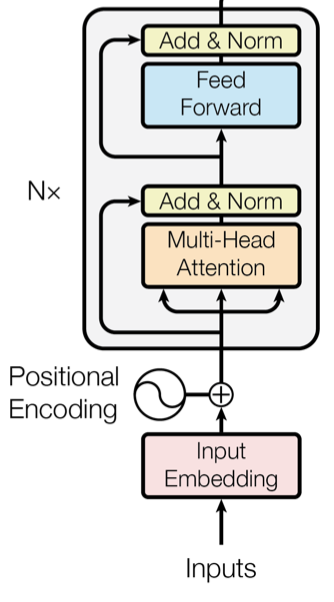

In [7]:
Image(filename='Images/Encoder.png')

### BERT

Использование модели очевидным образом разбивается на ее предобучение и fine-tuning. Во время первого модель учится на различных задачах с использованием неразмеченного текста. Во время второго берутся параметры, полученные во время предобучения, а затем файн-тьюнятся под конкретную задачу с использованием поверх берта нужной архитектуры. В этом то и кроется отличительная черта Берта: в нем нет никакой специфичности, его можно использовать для большого числа различных задач.

#### Model architecture

По сути, BERT - многослойный двунаправленный энкодер из Трансформера. 

Обозначим число слоев (блоков энкодера) - L, размерность hidden векторов H (все выходы всех частей Трансформера имеют одинаковую размерность), число self-attention head - A.

__$BERT_{BASE}$__: L=12, H=768, A=12 (Total parameters=110M)

__$BERT_{LARGE}$__: L=24, H=1024, A=16 (Total parameters=340M)

#### Input/Output Representations

Для того, чтобы Берт был способен справляться с большим числом различных задач, он спроектирован так, что на вход можно подавать как просто предложения, так и пары предложений (например, вопрос-ответ).

Для представления слов используются WordPiece embeddings, в словаре которых 30к английский слов, вполне себе достаточно. Первый токен каждой последовательности - специальный classification токен ([CLS]). Итоговое скрытое состояние модели, полученное из него используется для задач классификации. В случае использования на вход пар предложений (A, B) они разделяются токеном [SEP]. Также, предобучается два дополнительных эмбеддинга соотвествия первому и второму предложениям, которые добавляются к их векторам их токенов.

Для данного входного токена его входное представление формируются в результате суммирования: его эмбеддинга, segment-эмбеддинга соотвествия предложению и позиционного эмбеддинга.

#### Pre-trainining BERT

__Task #1: Masked LM__

Для того чтобы получить глубокие "двунаправленные" представления токенов фиксированная доля входа маскируется (используя специальный токен [MASK]) случайным образом, после чего модель пытается угадать, кто там находится. Такую процедуру называются "Masked LM". Итоговый hidden-вектор, соотвествующий маскированному токену, скармливается софтмаксу для получения предсказания. Они маскировали 15% входа.

Чтобы, насколько это возможно, избежать несоотвествия между предобучением и файн-тьюнингом, которое возникает из-за использования токена [MASK], случайно выбранный слова не всегда заменяются на этот токен: в 80% случаев им ставят токен [MASK], в 10% - случайный токен и в 10% - оставляют старый, после чего все равно используется softmax для предсказания истинного токена.

__Task #2: Next Sentence Prediction (NSP)__

Для того, чтобы обучить модель "понимать" связь между предложениями, во время пред-обучения используется задача "next sentence prediction". Более формально: во время выбора пар предложений (A,B) каждого примера для предобучения - в 50% случаев B берется как действительно следующее за A предложения (тогда пару помечают как IsNext), а в других 50% случаев B берется случайно из данных (и тогда помечаются NotNext). При этом, для принятия решения IsNext или NotNext используется final hidden вектор, полученный из токена [CLS].

__Pre-training data__

Для предобучения использовались BooksCorpus (800М слов) и English Wikipedia (2,500M слов).

#### Fine-tuning BERT

Тут все просто: на вход берту подается соотвествующий задаче вход, выход модели используется в зависимости от задачи. Пары предложений (A,B), используемые для пред-обучения, на этапе файн-тьюнинга в зависимости от задачи могут быть:

1) Парой предложений в задаче перефразирования

2) Парой гипотеза - "предпосылка" в задаче установления логического следствия

3) Вопрос-ответ в задаче QA

4) Текст-$\emptyset$ в задаче классификации или тэггирования.

#### Experiments

__GLUE (The General Language Understanding Evaluation__

Выход берта в позиции, соответвутствующей первому токену [CLF] проецировался на пространство числа выходных лейблов, затем для предсказания применялся софтмакс. Как итог - $BERT_{LARGE}$ всех порвал, на втором месте - $BERT_{BASE}$.

__SQUAD v1.1/ SQUAD v2.0__

Берты снова всех порвали, уже в задаче QA.


#### Conclusion

Ура, Берт всех победил!

#### Appendix

Статья, где был предложен трансформер:

https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf

Хорошая реализация Трансформера на торче:

http://nlp.seas.harvard.edu/2018/04/03/attention.html

## <a id=4>A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning</a>

https://dl.acm.org/doi/abs/10.1145/1390156.1390177

#### Abstract

В статье предлагается модель, которая для данного предложения одновременно атпутит предсказаниям по part-of-speech тэгам, chunk-ам, NER тэгам, семантическим смыслам, семнантически схожие слова и вероятность того, что это предложение вообще несет в себе какой-то смысл. Этого помогает достичь multitask learning подход (с использованием общих весов), а так же semi-supervised learning.

#### Introduction

Вместо изобретения различных архитектур для каждой задачи авторы хотят подробовать изобрести нечто более универсальное при наименьших затратах размеченных данных.

Модель обучается всем указанным задачам сразу (на размеченных текстах). Помимо этого, она обучается на неразмеченной википедии. Таким образом, получается semi-supervised подход. 

#### NTP tasks

* POS

* Chunking (shallow parsing) - разметка "кусков" предложения, имеющих некоторую "синтаксическую согласованность", такие как глагольные или существительные фразы. Каждое слово обозначается либо как начало чанка, не либо как его внутренняя часть.

* NER

* Semantic Role Labeling - нацелен на придание смысловой роли синтаксической составляющей предложения. Пример такой разметки: "$[John]_{ARG0}[ate]_{REL}[the \: apple]_{ARG1}$". При этом, каждому слову могут соотвествовать несколько тэгов.

* Language models - оценка вероятности след слова при данном прошлом.

* Semantic Related Words

#### General Deep Architecture for NLP

Они используют CNN над обучаемыми векторами представлений слов + Max Over Time (типа max pooling), затем идут обычные dense слои, в конце - софтмакс.

#### Multitasking with Deep NN

Это такой подход, когда мы пытаемся обучиться сразу нескольким задачам с целью получения взаимной выгоды между ними (типа одна задача дает возможность извлечь такие-то "признаки", другая - другие, короче, они сотрудничают и в результате получается лучшая обобщающая способнось).

Треин происходит следующим образом:

1) Выбрать новую задачу

2) Выбрать случайный пример для этой задачи

3) Сделать шаг град спуска

4) Вернуться к пункту 1

При этом, в их случае, модели имели лишь общие lookup-таблицы (таблицы с обучаемыми представлениями векторов)

Для обучениям множеству задач (по их мнению) возможны два подхода:

1) Сначала обучить фичи на одной задаче, затем использовать их как готовые в другой

2) Учиться сразу куче задач, если есть датасет, который может это позволить. Этот вариант им больше по нраву.

#### Leveraging Unlabeled Data

Их Language Model также обучается на неразмеченном датасете из Википедии, пытаясь предсказать для данного контекста и какого-то слова в нем, действительно для оно из него или же оно какое-то взятое случайно слово.

Кстати, сначала они обучали именно отдельно эту Language Model (целую неделю), потом использовали обученные веса для дообучения.

#### Experiments & Results

Ну у них получились неплохие эмбеддинги (еще бы, целая Википедия), получились какие-то непохие по тому времени результаты на различных задачах.

#### My conclusion

Мне не очень понравилась статья, видимо, слишком древняя. Возможно, для тех времен это было каким-то новшеством.

## <a id=5> Recurrent Neural Network for Text Classification with Multi-Task Learning </a>

https://arxiv.org/pdf/1605.05101.pdf

#### Abstract

В последнее время нейронки добились значительного прогресса во множестве NLP-задач. Однако, в большинстве случаев, модели обучаются на одной supervised задаче и часто страдают от нехватки данных. В связи с этим авторы решили попробовать MLT (multitask learning) подход, обучаясь сразу нескольким похожим задачам. Взяв за основу RNN, они разработали 3 возможных механизма обмена информации между таск-специфик и общими слоями.

#### Introduction

Глубокие сетки как правило нуждаются в больших объемах данных для обучения, так как имеют кучу параметров. Данные как правило дороги, поэтому часто модель сначала обучают на каком-нибудь большом неразмеченном тексте (например, предсказанию слов), а затем файн-тьюнят на целевую задачу, используя размеченную выборку. 

MTL использует связь между схожими задачами с целью улучшить качество классификации, обучаясь им параллельно. В основе таких моделей обычно лежит общее использоваие некоторых слоев, за которыми идут task-specific слои.

Они предлагают три возможные архитектуры: первая модель с использованием лишь одного общего слоя, вторая - каждая модель использует свои слои, но "каждый слой может читать информацию с другого слоя", третья - у каждой модели свои слои + есть общие слои для всех задач вместе. При этом, в третьей модели используется механизм гейтов, позволяющий каждой модели решить, нужна ли ей общая информация.

Утверждается, что такой мультитаск подход им помог обойти большинство state-of-the-art бейзлайнов на нескольких задачах.

#### RNN for Specific-Task Text Classification

Дабы избежать проблем с exploding и vanishing of gradients авторы решили использовать LSTM. 

-----------
Освежалка памяти для меня: каждая нода LSTM по сути есть коллекция векторов из $\mathbb{d}$ (d - предопределенная размерность): input gate $i_t$, forget gate $f_t$, output gate $o_t$, memory cell $c_t$ и hidden state $h_t$. Вычисления имеют вид:

$$
i_t = \sigma(W_ix_t+U_ih_{t-1}+V_ic_{t-1})
$$
$$
f_t = \sigma(W_fx_t+U_fh_{t-1}+V_fc_{t-1})
$$
$$
o_t = \sigma(W_ox_t+U_oh_{t-1}+V_oc_{t-1})
$$
$$
\widetilde{c}_t = tanh(W_cx_t + U_ch_{t-1})
$$
$$
c_t = f_t\odot c_{t-1}+i_t\odot \widetilde{c}_t
$$
$$
h_t = o_t\odot tanh(c_t)
$$

------------

Для получения предсказания по каждой из задач, они берут финальный hidden вектор (соотвествующий последнему обработанному слову) и применяют к нему софтмакс слой.

#### Three Sharing Models for RNN based Multi-Task Learning

Все три предложенные архитектуры можно увидеть на картинке

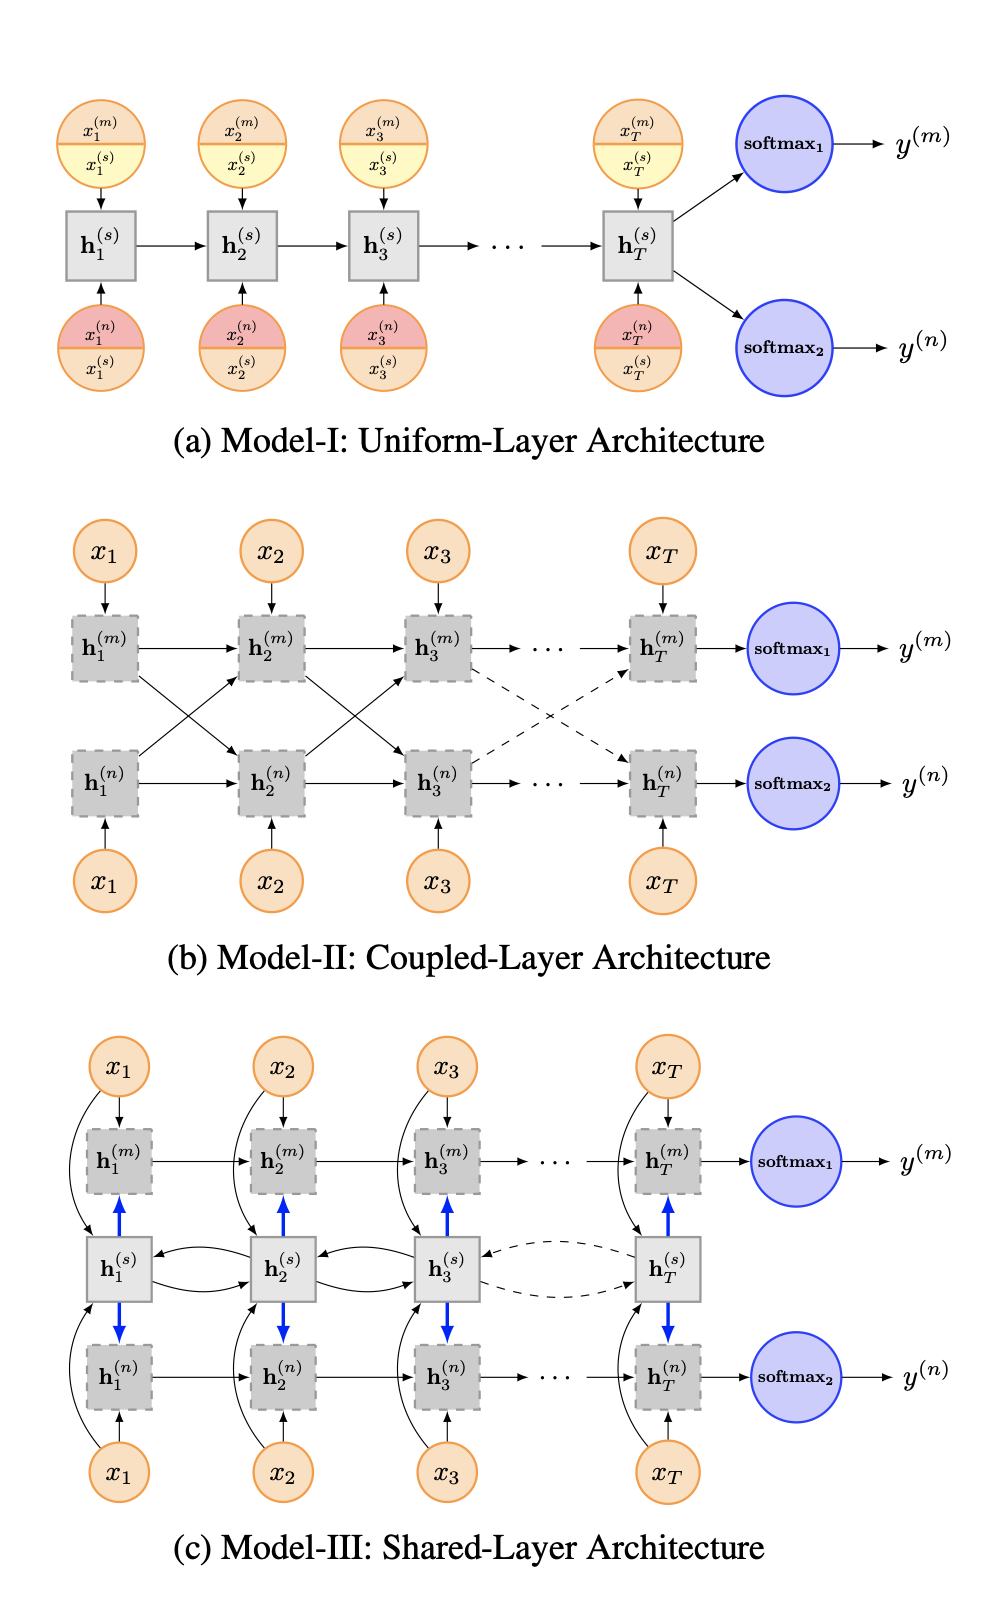

In [8]:
Image(filename="Images/Model2.png")

__Model 1__

В первой модели у всех задач общие слой LSTM и эмбеддинг также эмбеддинг слой за исключением их собственных эмбеддингов. Для задачи m вход $x_t$ состоит из двух частей:

$$
\hat{x}_t^{(m)} = x_t^{(m)} \oplus x_t^{(s)}
$$

где $x_t^{(m)}$ - task-specific эмбеддинг, $x_t^{(s)}$ - shared эмбеддинг, а $\oplus$ - операция конкатенации.

Финальное состояние LSTM:

$$
h_T^{(m)} = LSTM(\hat{x}^{(m)})
$$

__Model 2__

У каждой задачи свой LSTM, но они могут "общаться".

Для пары задач (m,n) обозначим на шаге t их скрытые состояния как $h_t^{(m)}$ и $h_t^{(n)}$. Для того, чтобы модели могли информацией друг с другом переопределяется кандидат на новое значение memory cell:

$$
\widetilde{c}_t^{(m)} = tanh\Big(W_c^{(m)}x_t + \sum\limits_{i\in(m,n)}g^{(i\rightarrow m)}U_c^{(i\rightarrow m)}h_{t-1}^{(i)}\Big)
$$

где $g^{(i\rightarrow m)}=\sigma(W_g^{(m)}x_t + U_g^{(i)}h_{t-1}^{(i)})$. Таким образом, на каждом шаге слой использует hidden вектор предыдущего шага всех остальных LSTM.

В конце концов получаются несколько финальных hidden-векторов для каждой из задач.

__Model 3__

Помимо обычной forward LSTM для каждой из задач, используется еще общий biLSTM-слой. Обозначим выход общего слоя на шаге t как: $h_t^{(s)} = \overset{\rightarrow}{h}_t^{(s)} \oplus \overset{\leftarrow}{h}_t^{(s)}$.

Модели могут сами "решать", нужна ли им информация из общего слоя при помощи гейта:

$$
\widetilde{c}_t^{(m)} = tanh\Big(W_c^{(m)}x_t + g^{(m)}U_c^{(m)}h_{t-1}^{(m)} + g^{(s\rightarrow m)}U_g^{(m)}h_{t-1}^{(m)}\Big)
$$

где $g^{(m)} = \sigma(W_g^{(m)}x_t + U_g^{(m)}h_{t-1}^{(m)})$ и $g^{(s\rightarrow m)} = \sigma(W_g^{(m)}x_t+U_g^{(s\rightarrow m)}h_t^{(s)})$

#### Training

Во время тренировки лосс определяется как линейная комбинация лоссов каждой из подзадач:

$$
\Phi = \sum\limits_{m=1}^{M}\lambda_mL(\hat{y}^{(m)}, y^{(m)})
$$

(правда откуда берутся лямбы они вроде не упомянули).


Так как данные для каждой из подзадач могут отличаться, то тренировка снова происходит в стохастической манере:

1) Берем случайную задачу

2) Берем случайный пример из обучающей выборки для этой задачи

3) Делаем шаг градиентного спуска

4) Возвращаемся к шагу 1

В 1 и 3 моделях после этапа общего обучения можно пофайнтьюнить на любую из задач.

В 3й модели можно предобучить общий слой на unsepervised задаче.

#### Experiments & results

Третья версия модели оказалась наиболее удачной из всех и обошла всякие топовые модели своего времени

#### My conclusion

Как по мне, идея хорошая, но архитектура простовата.

## <a id=6>Semi-supervised Multitask Learning for Sequence Labeling</a>

https://arxiv.org/pdf/1704.07156.pdf

#### Abstract

Авторы статьи предлагают sequence labeling модель, которая помимо этого учится на задаче предсказания окружающих слов для каждого из слов датасета. Такой подход стимулирует модель учиться общим языковым структурам и "понимать" как синтаксические, так и семантические особенности слов, что оказывается очень полезным для sequence labeling. Утверждается, что такой подход дает очень неплохие результаты.

#### Introduction

Последние работы в области sequence labeling показывают, что нейронки могут и самостоятельно, без всяких хитрых разметок и "подсказок", извлекать очень даже неплохие фичи из входных токенов.

Одна из главных проблем задач типа sequence labeling состоит в большой разреженности лейблов: так, например, в CoNLL 2003 NER датасете лишь 17% токенов имеют лейбл. И если обучаться лишь на них, то будет теряться множество полезной информации из остальных слов с "общим" лейблом.

Определенные части предлагаемой модели будут иметь forward и bachward структуру, однако предсказание лейблов будет происходить на основе контекста с обеих сторон. 

Ну и как всегда, какая же уважающая себя статья без превосхождение предыдущих state-of-the-art моделей.

#### Neural Sequence Labeling

Модель берет на вход предложение, разделенное на токены и назначает каждому токену лейбл, используя biLSTM.

Входные слова сначала отображаются в эмбеддинги и только затем подаются в LSTM, которая дает на выходе векторы скрытых состояний для каждого шага времени t:

$$
\overset{\rightarrow}{h_t} = LSTM(x_t, \overset{\rightarrow}{h_{t-1}})
$$
$$
\overset{\leftarrow}{h_t} = LSTM(x_t, \overset{\leftarrow}{h_{t-1}})
$$
$$
h_t = [\overset{\leftarrow}{h_t}, \overset{\rightarrow}{h_t}]
$$

Сконкатенированный вектор $h_t$ подается в feedforward слой, чтобы позволить модели выудить нужные ей фичи из обоих контекстов совместно:

$$
d_t = tanh(W_dh_t)
$$

Для предсказания лейбла для каждого из токенов далее используется либо софтмакс, либо CRF. В первом случае модель предсказывает распределение над токенами для данного слова:

$$
P(y_t|d_t) = softmax(W_od_t) = \frac{e^{W_{o,k}d_t}}{\sum_{\widetilde{k}\in K}e^{W_{o,\widetilde{k}}d_t}}
$$

где K - множество всех лейблов, $W_{o,k}$ - k-я строка матрицы $W_o$. Модель оптимизируется на минимизации categorical crossentropy, что эквивалентно минимизации the negative log-probality правильных лейблов:

$$
E = - \sum\limits_{t=1}^{T}log(P(y_t|d_t))
$$

Однако, такие предсказания делаются для каждого из лейблов независимо, что не всегда хорошо. Напривер, в задаче NER есть сильная взаимосвязь между соседними лейблами и лучше стараться моделировать эти связи явным образом. Для этого был придуман CRF (Conditional Random Field), который позволяет модели искать оптимальные последовательности лейблов. Модель оптимизируется максимизацией скора правильной последовательности лейблов и минимизации скоров всех друг последовательностей:

$$
E = -s(y) + log\sum\limits_{\widetilde{y}\in\widetilde{Y}}e^{s(\widetilde{y})},
$$

где s(y) - скор нашей последовательности y, а $\widetilde{Y}$ - множество всевозможных последовательностей лейблов.

Модель также учится character-level представлениям для получения бОльшего профита: каждому символу сопоставляется его эмбеддинг и затем он подается через biLSTM. Полученные hidden-веторы конкатенируются и проходят через нелинейное преобразование. Полученный эмбеддинг слова складывается взвешенным образом с word-level эмбеддингом при помощи динамического механизма взвешивания для поддержания баланса между обоими эмбеддингами. Модель таким образом может извлекать charater-based структуры, а также справляться с незнакомыми словами.

#### Language Modeling Objective

В дополнении к задаче предсказания лейблов вводится оптимизация частей модели на задаче предсказания следующих слов. Польза в том, что модель при этом можем выучить какие-то общие языковые структуры, совершенно не требуя дополнительных размеченных данных.

Простой способ реализации такой задачи - добавить второй, "паралельный" выходной слой ддя каждого токена, который будет оптимизироваться на предсказание следующего слова. Однако важно делать предсказание следующего слова, не подглядывая в будущее, поэтому оно будет делаться с использованием вектора $\overset{\rightarrow}{h_t}$ в прямой LSTM, и с использованием веткора $\overset{\leftarrow}{h_t}$ в обратной. Соотвествующим образом будет происходить оптимизация.

Эти скрытые векторы отображаются в новое пространвсто с использованием нелинейности:

$$
\overset{\rightarrow}{m_t} = tanh(\overset{\rightarrow}{W}_m\overset{\rightarrow}{h_t})
$$
$$
\overset{\leftarrow}{m_t} = tanh(\overset{\leftarrow}{W}_m\overset{\leftarrow}{h_t})
$$

При этому, новые векторы имеют меньший размер, так как предсказание слов - не главная цель и здесь можно поэкономить на ресурсах, при этом побуждая модель извлекать более общие языковые структуры.

Полученные представления проходят через софтмакс для предсказания предыдущих и следующих слов:

$$
P(w_{t+1}|\overset{\rightarrow}{m_t}) = softmax(\overset{\rightarrow}{W_q}\overset{\rightarrow}{m_t})
$$
$$
P(w_{t-1}|\overset{\leftarrow}{m_t}) = softmax(\overset{\leftarrow}{W_q}\overset{\leftarrow}{m_t})
$$

Оптимизируется в этот раз вероятность слова при данной предыстории:

$$
\overset{\rightarrow}{E} = - \sum\limits_{t=1}^{T-1}log(P(w_{t+1}|\overset{\rightarrow}{m_t}))
$$
$$
\overset{\leftarrow}{E} = - \sum\limits_{t=2}^{T}log(P(w_{t-1}|\overset{\leftarrow}{m_t}))
$$

Полученные дополнительные objective-ы добавляются к введенному в задаче sequence labeling:

$$
\widetilde{E}  = E + \gamma(\overset{\rightarrow}{E}+\overset{\leftarrow}{E}),
$$

где $\gamma$ - параметр, используемый для контроля важности "побочной" задачи.

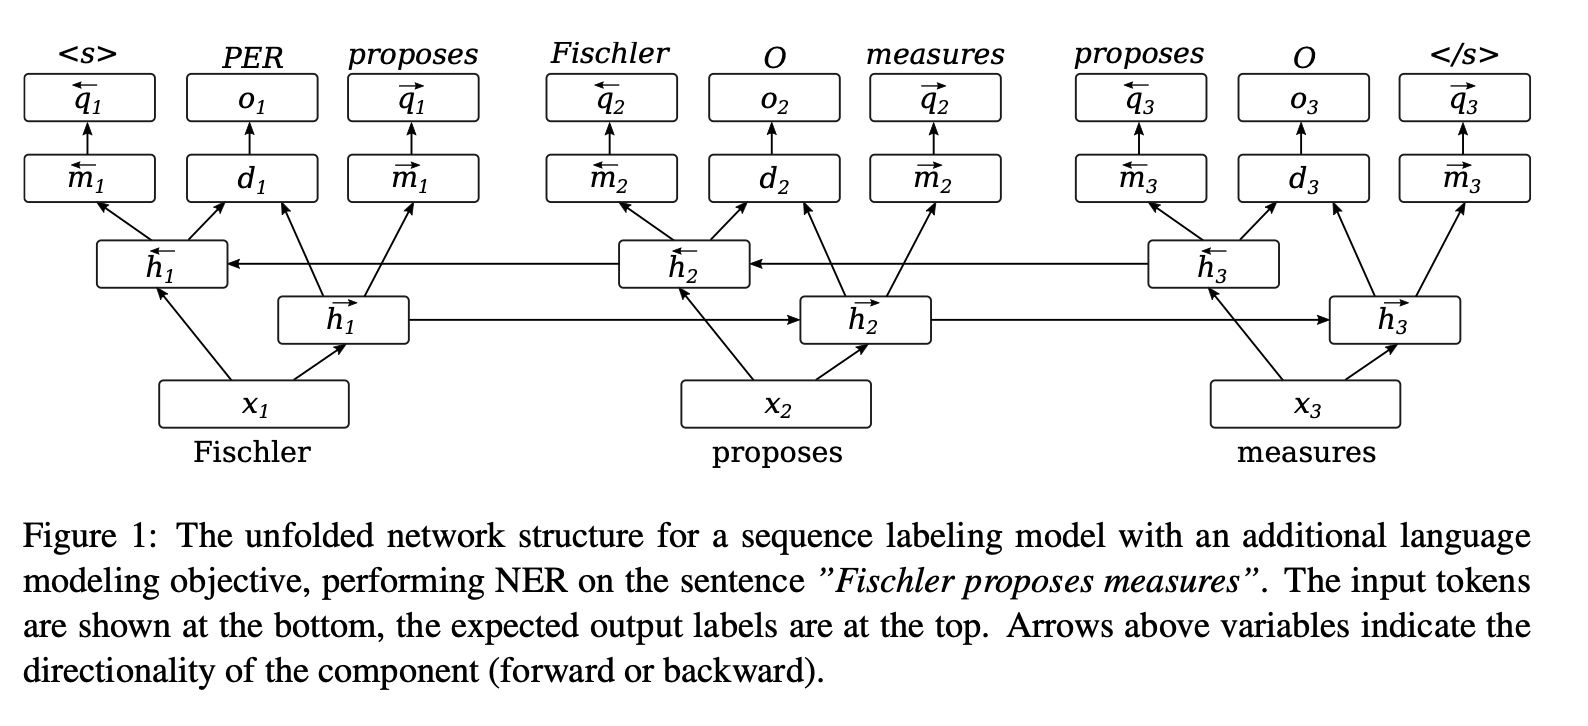

In [2]:
Image("Images/model3.png")

В итоге мы добавили 4 дополнительных матрицы весов, которые не влияют значительно на вычислительную сложность. Более того, во время теста они не будут использоваться.

#### Evaluation setup

В этой части статьи стоит отметить, что авторы нашли полезным использовать дропаут над входными эмбеддингами: они взяли его равным 0.5. Соотвественно, во время теста веса умножались на 0.5.

Параметр $\gamma$, контролирующий вклад задачи предсказания слов, был взят равным 0.1. 

#### Experiments and results

Эксперименты авторов, в частности на примерах задач NER, показали небольшое превосходство над всякими state-of-the-art-ами. Также были показаны результаты, согласно которым, добавление второстепенной задачи предсказания слов дает значительное улучшение в перформансе модели.

## <a id=7>When is multitask learning effective? Semantic sequence prediction under varying data conditions
</a>

https://arxiv.org/pdf/1612.02251.pdf

Опишу немного показавшихся мне интересными мыслей из этой статьи.

В целом, авторы данной статьи довольно скептически относятся к пользей мультитаска. Применив его к 5 задачам, они получили значительный профит лишь в одном случае, однако, как по мне, они брали немного странные "вспомогательные" задачи для мультитаскинга. Архитектура модели использовалась совершенно стандартная: 3 слоя biLSTM, на вход которым подается конкатенация из предобученных эмбеддингов и characler-level представлений, полученных при помощи вспомогательный biLSTM. На основе выходных hidden-векторов делались предсказания для каждой из задач.

Интересно то, что отметили авторы относительно смысла мультитаска:

Принцип работы мультитаска в том, что модель, обучаясь на каких-то вспомогательных задачах, получает от этого улучшение к общему качеству, то есть улучшение в понимании каких-то общих структур языка.

## <a id=8> A Multi-lingual Multi-task Architecture for Low-resource Sequence Labeling </a>

https://www.aclweb.org/anthology/P18-1074.pdf

#### Abstract 

Авторы предлагают многоязычную мультитаск архитектуру supervised модели, требующую минимальное количество размеченных даных в задаче sequence labeling. В своей модели они комбинируют различные transfer-ы, используя два слоя шэринга параметров. На первом слое контруируется архитекрутный "базис", в котором модель старается найти более общие представления слов и извлекает фичи для всех моделей. На втором уровне авторы применяют различные стратегии шэринга параметров для различных transfer схем. В итоге, модель оказывается достаточно эффективной относительно требуемых ресурсов (например, в случае, когда размеченных предложений менее 200). 

#### Introduction

Как правило, при обучениям различным задачам в NLP, мы обучаем одну независимую модель для какой-то задачи в соотвествии с ее сферой и имеющимися данными. Однако, если у нас имеется несколько схожих задач, почему бы не использовать знания, полученные в одной задаче, чтобы решить другую. MLT - один из самых эффективных подходов для переноса знаний между задачами.

Авторы отмечают, что большинство предыдущих исследований никаким образом не концентрировались на возможной нехватке данных, которая часто является центральной проблемой, особенно при желании решать поставленную задачу на различных языках.

Чтобы справиться с озвученными опрасами, авторы предлагают _multi-lingual multi-task_ архитектуру с двумя уровнями шэринга параметров. На первом делятся character embeddings, character-level CNN и word-level LSTM. Эти компоненты используются в качестве базиса для связи различных моделей и переноса знаний между ними. На втором уровне применяются различные стратегии сообщения между моделями для различных схем обмена знаниями. Например, ими используется один общий выходной слой для всех Name Tagging задач с целью "деления" task-specific знаний (токен I-PER не может быть назначен первому слову последовательности и тп).

Их результаты показывают, что такая модель способна эффективно передавать знания между своими задачами, не требуя при этом большого количества данных для вспомогательных задач.

### Model

#### Basic Architecture

Классические архитектуры для работы с sequence labeling зачами являются HMM и CRF, однако использовались они раннее лишь поверх всяких собранных руками фич, чего, конечно, хочется избежать, ведь они плохо переносятся, например, между различными языками. Для этого были разработаны модели, работающие с эмбеддингами: например, LSTM-CNN или LSTM-CRF.

LSTM-CFR хорошо подходят к мульти-язычным задачам по трем причинам:

1) Они учатся фичам из word and charater эмбеддингов и поэтому требуют лишь небольшого feature engineering-а

2) Вход и выход каждого слоя - всегда векторы, поэтому моделям легко делиться своими компонентами

3) Символьные эмбеддинги могут быть мостом для передачи морфологической и семантической информации между языками со схожими алфавитами.

Выглядит эта архитектура следующим образом:

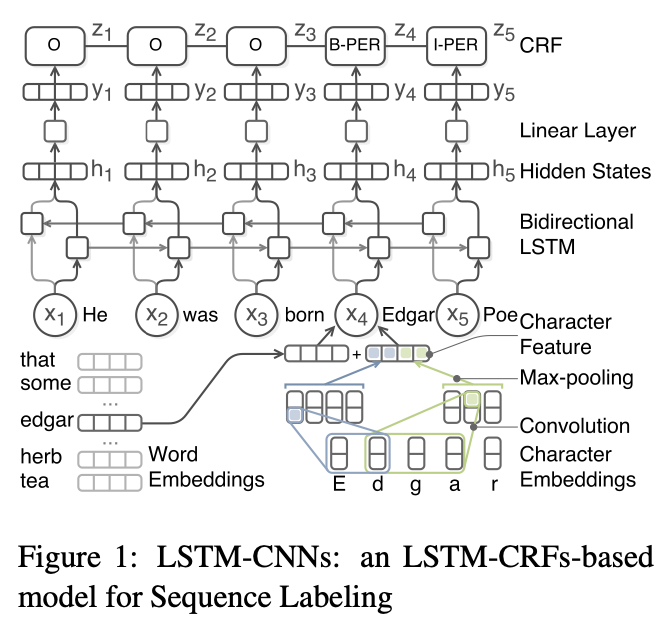

In [3]:
Image("Images/LSTM-CRF.png")

Для того, чтобы учитывать корреляции между тэгами, CRF также старается моделировать вероятности данных последовательностей тэгов, поэтому, при входной последовательности __x__ длины L, выходной __y__ и последовательности тэгов __z__, скор последовательноти тэгов определяется как:

$$
S(x,y,z) = \sum\limits_{t=1}^L (A_{z_{t-1},z_t} + y_{t,z_t})
$$

A - матрица переходов, y - скор, соотвествующий вероятности тэга z у t-го слова. При данной истинной последовательности тэгов, модель старается максимизировать следующую цель во время обучения:

$$
O = logP(z|x) = S(x,y,z)-log\sum\limits_{\widetilde{z}\in Z}e^{S(x,y,\widetilde{z})}
$$

где Z - всевозможные последовательности тэгов.

Также, авторы статьи прогоняли полученные векторы символьных представлений через highway network, который может как добавить некоторую нелинейность, так и сохранить вектор в прежнем виде.

#### Multi-task Multi-lingual Architecture

MTL можно ориентировать на разные задачи по-разному. Авторы постарались усилить акцент на производительности мало-ресурных задач (main task), а также приобретать знания с дополнительных, побочных задач (auxiliary task).

Чтобы совместно обучать несколько моделей используется мульти-таск лернинг с шэрингом параметров. Допустим, $\Theta_i$ - множество параметров модели $m_i$, а $\Theta_j$ - множество параметров модели $m_j$. Тогда обозначим за $\Theta_{i,j} = \Theta_i \cap \Theta_j$ - множество их общих параметров. В процессе оптимизации модели $m_i$ - оптимизируются ВСЕ ее параметры, а значит и частично, модель $m_j$, что дает им возможность "делиться" знаниями.

Напомню, что для того, чтобы совместить различные модели обмена данными в одну единую архитектуру, авторы разработали два уровня шэринга параметров. На первом уровне собирается базис модели: формируются символьные эмбеддинги, попадают в CharCNN и затем biLSTM. Эти части модели являются общими для всех. При этом стоит заметить, что общие символьные эмбеддинги и CharCNN имеют смысл лишь у языков со схожими алфавитами.

Поверх указанного базиса применяются различные стратегии шэринга параметров в зависимости от различных схем "переноса". Для кросс-задачного переноса (cross-task transfer) авторы используют одни и те же представления слов, так что эти задачи могут совместо прокачивать эти эмбеддинги. Для кросс-языкового переноса шэрится линейный слой и CRF для переноса знаний, связанных со спецификой задачи, как, например, скор перехода между тэгами.

__Word Embeddings__

Помимо использования символьных эмбеддингов, авторы используют предобученные представления слов, которые также оптимизируются во время обучения модели. Поэтому, task-specific знания может быть "закодировано" в представление слова и использовано далее кем-то другим. Для языков с небольшим объемом даже неразмеченных данных, авторы решили смешивать эти небольшие объемы с данными "богатых" языков для обучения таких вот совместных предтавлений слов. При этом правда будут объединены и их словари. Эксперименты показывают, что такой подход реально может помочь производительности малоресурсной задачи.

__Linear layer and CRF__

Как уже было сказано, различные языки делят между собой в пределах одной задачи CRF слой, а также линейный слой (при этом имея еще один линейный, уже связанный непосредственно с этим языком). 

Выходы с общего и частоного линейных слоев ($y^u$ и $y^s$) комбинируются следующим образом:

$$
y = g\odot y^s + (1-g)\odot y^u
$$

где $g = \sigma(W_gh+b_g)$, h - выход LSTM.

Архитектура всей модели выглядит так:

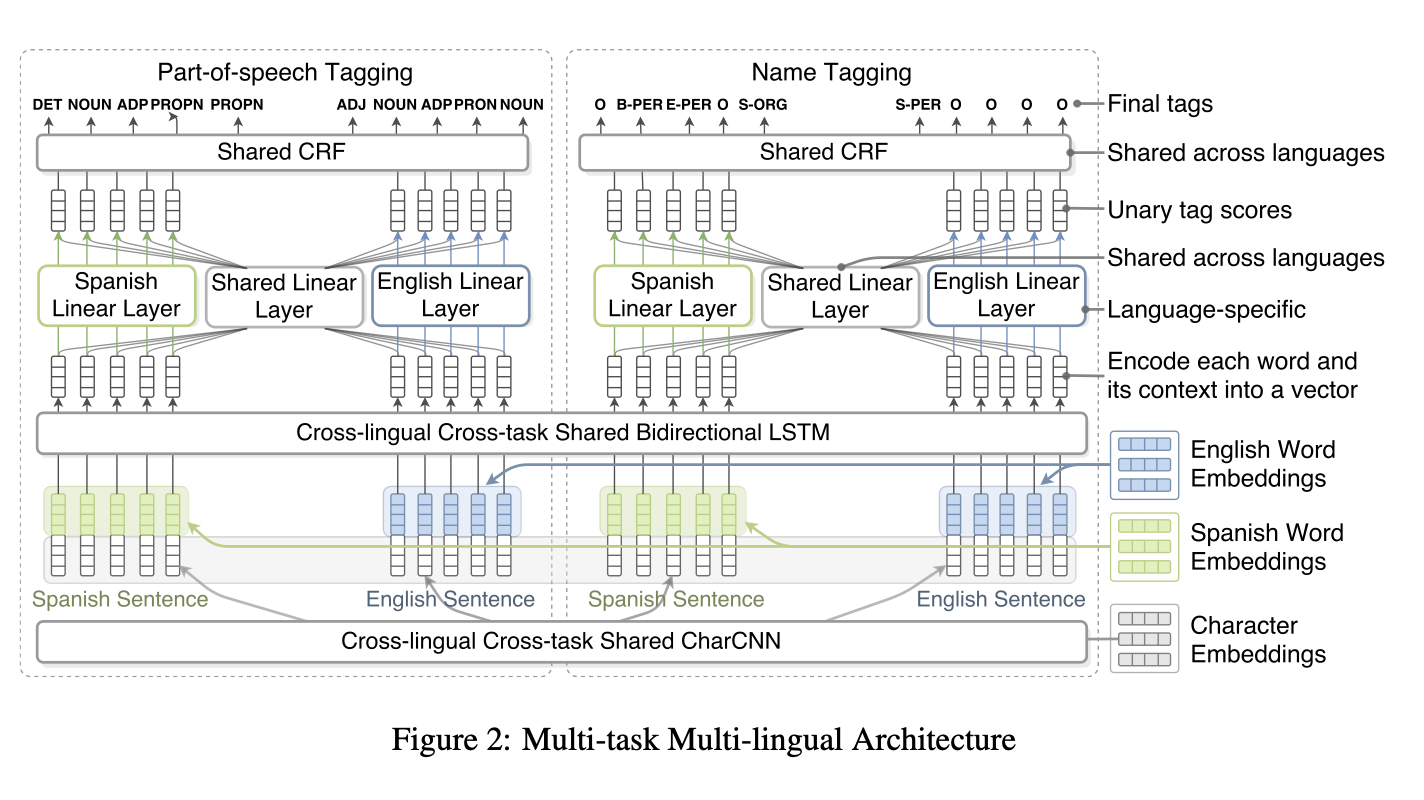

In [8]:
Image("Images/Multi-lingual-Multi-task.png")

Интересным образом авторы осуществляют треин: на каждом шаге случайным образом выбирается задача:

на каждом шаге задача $d_i$ берется с вероятностью $\frac{r_i}{\sum_jr_j}$, где $r_i = \mu_i\zeta_i\sqrt{N_i}$. $N_i$ - число тренировочных примеров задачи, $\mu_i$ (или $\zeta_i$) принимает значение 1 если задача (или язык) задачи $d_i$ совпадает с целевой (таргет) задачей, а иначе - принимает значение 0.1. Например, возьмем задачу English Name Tagging как целевую, тогда для задачи English Name Tagging $\mu=0.1$, $\zeta=1$. Таким образом, меньшая вероятность назначается более редким задачам (чтобы не переобучиться на них), а также учитывается "побочность" различных задач.

#### Experiments and Results

Их модель оказалась значитель лучшей чем бейзлайны (на маленьких обучающих выборках) сразу для нескольких языков. F-score моментально был на достаточно неплохом уровне. Вот, например, график для Чешского языка:

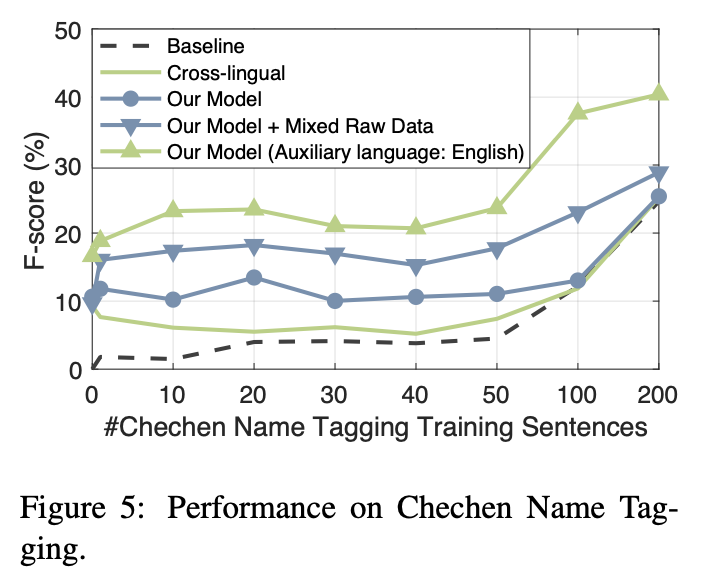

In [9]:
Image("Images/Multi-lingual-Chech.png")

#### My conclusion

Хорошая и полезная статья. Можно из нее чего-нибудь потом подчерпнуть.

## <a id=9>Prototypical Networks for Few-shot Learning</a>

https://proceedings.neurips.cc/paper/2017/file/cb8da6767461f2812ae4290eac7cbc42-Paper.pdf

#### Abstract

Авторы предлагают Prototypical сети для задачи few-shot классификации, в которой классификатор должен суметь обобщиться на новые классы, которые он не видел на треине при данном небольшом количестве экземпляров каждого нового класса. Прототипированные сети "учатся" метрическому пространству, в котором классификация может быть произведена путем подсчета расстояний до "прототипов", символизирующих каждый класс. В сравнении с другими современными на момент выхода статьи подходами во few-shot-е, они отображают более простое "индуктивное смещение", что оказывается очень полезным в случае работы с ограниченным объемом данных и помогает достичь очень крутых результатов.

#### Introduction

Few-shot learning - задача, в которой классификатор может быть адаптирован для извлечения новых классов на основании небольшого (few) числа примеров. Наивный подход, состоящий в простом дообучении на них, очевидно, приведет к переобучению на это небольшое число данных. С другой стороны, люди отлично справляются и с one-shot learning-ом, а чем сети хуже??

До выхода этой статьи было два популярных подхода к решению этой задачи: Matching Networks, которые используют attention-механизм над обученными эмбеддингами размеченных примеров (support set) для предсказания класса для неразмеченных примеров (query set). Мэтчинг сетки можно интерпретировать как взвешанный KNN в пространстве эмбеддингов. Примечательно, что эта модель использует минибатчи (episodes) во время обучения, где каждый "эпизод" является как бы few-shot заадчей. Ravi and Larochelle в своей статье "Optimization As A Model For Few-shot learning" развили эту идею еще дальше и предложили meta-learning подход. Он включает в себя тренировку LSTM-а для проведения обновлений классификатора для данного "эпизода", чтобы он хорошо обобщался на тестовый набор. Вместо обучения одной модели на нескольких эпизодах, LSTM meta-learner обучает новую модель на каждом эпизоде.

Авторы, по их словам, предлагают решение проблемы переобучения. Так как данные сильно ограничены, то можно сделать предположение, что классификатор должен иметь очень простое индуктивное предположение (inductive bias) (то есть очень простые гипотезы о природе целевой функции, которую мы хотим аппроксимировать). Прототипированные сети построены на предположении, что для каждого класса существует эмбеддинги, вокруг которых концентирируются кластеры точек этих классов. Для того, чтобы обучиться таким эмбеддингам, они обучают модель нелинейному отображению входного пространства в пространство эмбеддингов, в котором прототип класса (тот самый, вокруг которого концентируются) берется как среднее входного множества в пространстве эмбеддингов. Классификация таким образом проводится для вложения каждого запроса (query) простым поиском ближайшего прототипа класса. 

Они также решили попробовать этот же подход для решения zero-shot задачи, в котором каждый класс задается на основании высокоуровненего описания при помощи некоторых мета-данных, а не при помощи представителей этого класса. На основании этих описаний аналогично находится прототип класса и классификация происходит на основании поиска ближайшего прототипа.

В своей статье авторы рассматривают различные способы подсчета расстояний при помощи дивергенции Брэгмана, например, Евклидовой нормы, которая оказывается лучшим выбором, особенно в сравнении со стандартным косинусным расстоянием.

### Prototypical Networks

#### Notation

Допустим нам дан маленький набор из N примеров: $S = \{(x_1, y_1), ..., (x_N, y_N)\}$, где $x_i \in \mathbb{R}^D$, а $y_i \in \{1, ..., K\}$ - метка класса. $S_k$ - набор примеров из класса k.

#### Model

Prototypical Networks находят представление (прототип) размерности M ($c_k \in \mathbb{R}^M$) для каждого класса при помощи функции $f_\Phi: \mathbb{R}^D\rightarrow \mathbb{R}^M$ с обучаемыми параметрами $\Phi$. Каждый прототип есть среднее своего класса в пространстве эмбеддингов:

$$
c_k = \frac{1}{|S_k|}\sum\limits_{(x_i,y_i)\in S_k}f_\Phi(x_i)
$$

Для данной функции дистанции $d: \mathbb{R}^M \times \mathbb{R}^M \rightarrow [0,+\infty)$, прототипированная сеть находит распределение над классами для запроса, основываясь на софтмаксе:

$$
p_\Phi(y=k|x) = \frac{exp(-d(f_\Phi(x), c_k))}{\sum_{k'}exp(-d(f_\Phi(x), c_{k'}))}
$$

Обучение производится минимизацией отрицательной лог-вероятности $J(\Phi) = -log\:p_\Phi(y=k|x)$ настоящего класса при помощи SGD. Эпизды формируются случайным выбором подмножества классов, затем выбором подмножества примеров из этих классов для построения support set, остальные точки используются как запросы.

Псевдокод алгоритма имеет вид:

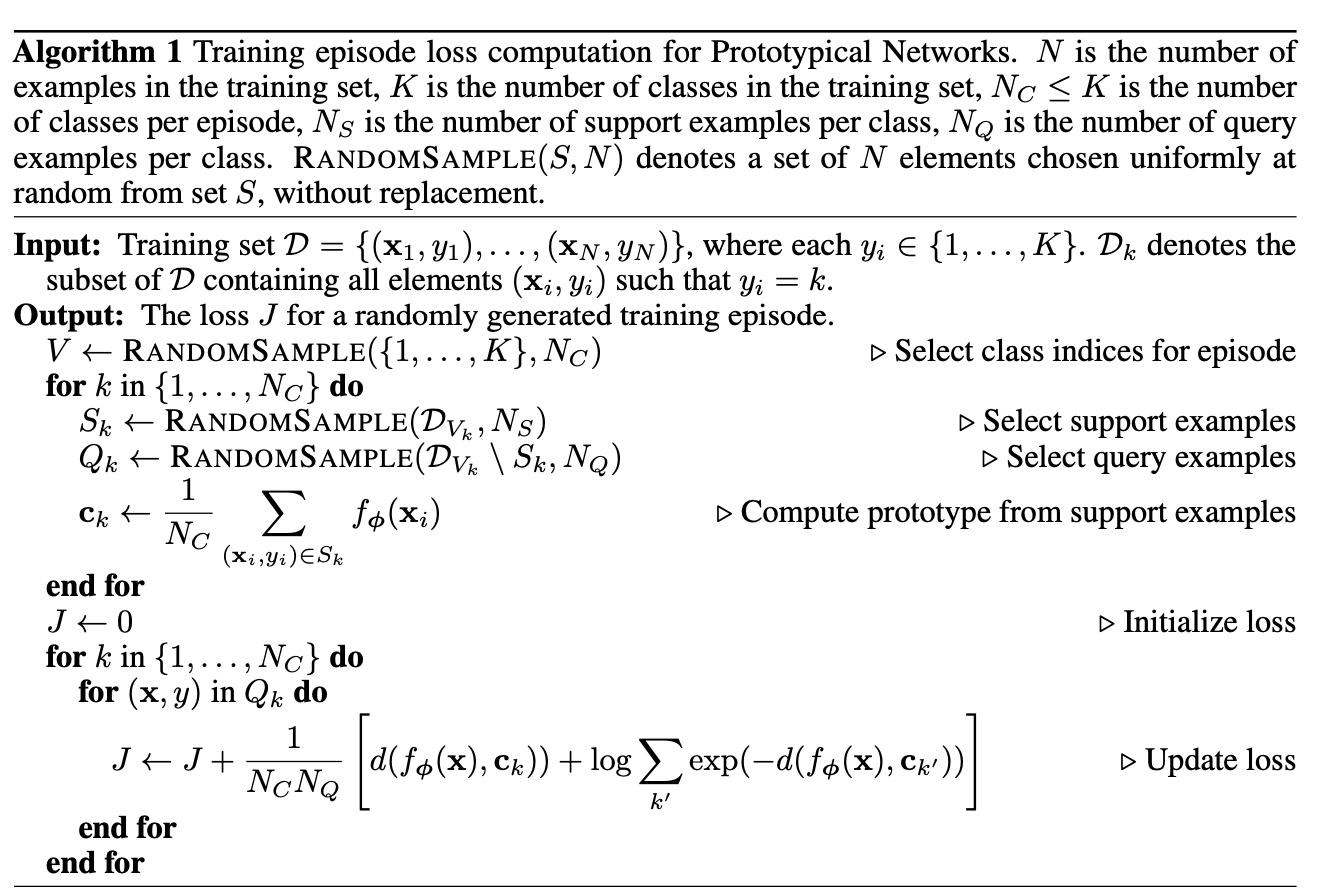

In [15]:
Image("Images/Prototypical-algorithm.png")

А сам процесс инференса можно изобразить как:

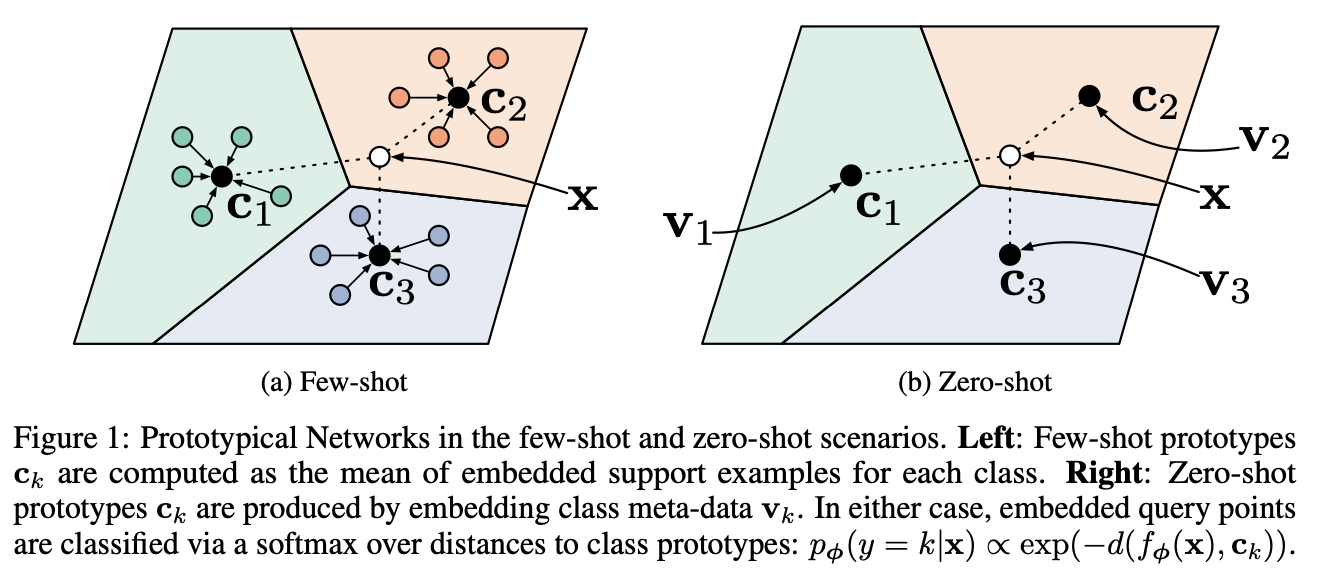

In [16]:
Image("Images/Prototypical-figure.png")

 #### Prototypical Networks as Mixture Density Estimation
 
Для определенного класса дистанций, известного как регулярные дивергенции Брегмана алгоритм Прототипированных сетей эквивалентен проведению "оценки плотности смеси" на support set-е при помощи плотности из экспоненциального семейства. Дивергенция Брегмана определяется как:

$$
d_\phi(z, z') = \phi(z) - \phi(z') - (z-z')^T\nabla\phi(z')
$$

где $\phi$ - дифференцируема и строго выпукла.

Так вот, было показано, что если взять такую функцию функцию за функцию расстрояния, то среднее support set дает точку, имеющую минимальное расстояние до точек класса!

Более того, в случае принадлежности экспоненциальному семейству распределений, вероятность принадлежности классу может быть выражена как функция от расстояния и мы таким образом получаем оценку плостности экспоненциального распредения, определенным функцией $d_\phi$.

#### Reinterpretation as a Linear Model

Допустим, мы используем Евклидово расстояние: $d(z,z')=||z-z'||^2$. Тогда, распишем показатель экспоненты:

$$
-||f_\Phi(x)-c_k||^2 = -f_\Phi(x)^Tf_\Phi(x) + 2c_k^Tf_\Phi(x) - c_k^Tc_k
$$

Первый член не зависит от класса, а поэтому не влияет на софтмаксовую вероятность. Преобразуем оставшуюся часть:

$$
2c_k^Tf_\Phi(x) - c_k^Tc_k = w_k^Tf_\Phi(x) + b_k
$$

Получается, мы обучаем линейную модель над полученным эмбеддингом. Несмотря на кажущуюся простоту, нелинейность в отображении $f_\Phi$ как раз и дает большую эффективность.

#### Design Choices

__Distance metric__ что делает Prototypical Networks лучше чем Matching? А то, что в первых мы используем Брэгмановские расстояния, а во вторых - косинусное, которые не является дивергенцией Брэгмана и поэтому эквивалентность оценке распределения смеси, которую мы описали выше, уже не работает.

__Episode composition__ Для создания эпизодов во время обучения надо определиться с объемом выбираемого подмножества классов $N_c$ и размером суппорта $N_S$. Авторы заметили, что первый параметр лучше всего выбирать, используя held-out validation set, а второй брать одинаковым для треина и теста.

#### Zero-shot learning

Мы имеем мета-описание класса, на основе которого находится мета-вектор: $v_k$, далее, прототип класса определяется как: $c_k=g(v_k)$. 

#### Experiments

Эксперименты показали суперские результаты, наравне с MAML (иногда и лучше). Его мы обсудим дальше.

## <a id=10> Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks </a>

https://arxiv.org/pdf/1703.03400.pdf

#### Abstract

Авторы предлагают алгоритм мета-обучения, являющийся model-agnostic в смысле что эта модель сравнима с любой моделью, обученной на градиентном спуске и применима к множеству различных проблем, таких как классификация, регрессия и обучение с подкреплением. Цель мета-обучения - обучить модель на различных задачах так, что после этого она сможет решить новую задачу, используя лишь небольшое число примеров. В подходе авторов параметры модели неявно обучены так, что небольшое число шагов градиентного спуска с использованием небольшого объема данных даст хорошее качество на новой задаче. Иначе говоря, fine-tune-ить такую модель очень просто. С использованием этого подхода можно добиться state-of-the-art-а во многих задачах.

#### Introduction

Meta-learning = learning to learn.

Ключевая идея, лежащая в основе их подхода - обучать начальные параметры модели так, что она будет иметь максимальную производительность на новой задаче после нескольких шагов градиентного спуска, посчитанных на небольшом объеме данных. Модель, которая может быстро на что-то дообучиться, должна иметь хорошее внутреннее представление множества подобных задач, именно это и дает, по представлению авторов, их подход.

С точки зрения "динамических систем" их процесс обучения модели может быть рассмотрен как максимизация чувствительности лосса на новых задачах по отношению к параметрам: когда чувствительность высока, малые локальные изменения параметров могут привести к огромным улучшениям в лоссе.

### Model-Agnostic Meta-Learning

#### Meta-Learning Problem Set-Up

По факту, во время мета-обучения каждая задача из обучения рассматривается как один training example. 

Рассмотрим модель $f$, она отображает наблюдения $x$ в выходы $a$. Во время мета-обучения, модель учится адаптироваться к большому, или даже бесконечному числу задач. Так как мы хотим применять нашу модель ко множеству различных задач таких как классификация, регрессия и тд, введем общие обозначения. Формально, каждая задача $T = \{L(x_1, a_1, ..., x_H, a_H), q(x_1), q(x_{t+1}|x_t, a_t), H\}$ состоит из функции потерь $L$, какого-то распределения над наблюдениями $q(x_1)$, вероятности перехода $q(x_{t+1}|x_t, a_t)$ и эпизода длины H. Так, в i.i.d. задаче обучения с учителем H=1. Модель может генерить примеры длины H выбором выхода $a_t$ на шаге t. 

В сценарии мета-обучения мы рассмариваем распределение над задачами $\rho(T)$ и хотим чтобы наша модель могла "адаптироваться" к нему. В постановке K-shot-а модель обучена учиться задаче $T_i$, полученной из распределения $\rho(T)$ на основании K примеров, взятых из $q_i$ и лосса $L_{T_i}$, полученного из задачи $T_i$. Во время мета-обучения задача $T_i$ выбирается из $\rho(T)$, модель обучается на K примерах с учетом лосса $L_{T_i}$ и затем тестируется на новых примерах из $T_i$. Модель $f$ затем улучшается на основании рассмотрения того, как ошибка теста на новых данных из $q_i$ меняется по отношению к параметрам. Таким образом, тестовая ошибка на примерах из $T_i$ на самом деле служит обучающей ошибкой в процессе мета-обучения. В конце процесса мета-обучения новые задачи берутся из $\rho(T)$ и "мета-качество" оценивается при помощи качества модели после обучения на K примерах.

#### A Model-Agnostic Meta-Learning Algorithm

В отличие от предыдущих подходов, где авторы пытались обучиться сразу на всех данных или получить какие-то странные feature эмбеддинги, их метод обучает параметры некой стандартной модели во вреям мета-обучения так, что она становится готова быстро чему-то дообучиться. Интуиция в том, что некоторые внутренние представления более "переносимы" чем другие. Например, нейронка может обучиться внутренним представлениям, которые широко применимы для всех задач из $\rho(T)$, нежели какой-то одной задаче. Но как можно поощрить появление таких универсальных представлений? Авторы использовали неявный подход: так как модель в последствии будет дообучена на новую задачи при помощи градиентного спуска, можно попробовать обучить ее таким образом, что этот градиентный спуск быть приводить к большому прогрессу на новых задачах из $\rho(T)$ без переобучения! На деле, главная цель мета-обучения - найти параметры, которые будут _чувствительны_ к изменениям в задаче в том смысле, что малые изменения параметров будут давать значильные улучшения в лоссе для любой задачи из $\rho(T)$ при изменении в направлении градиента соответствующей потери (Figure 1).

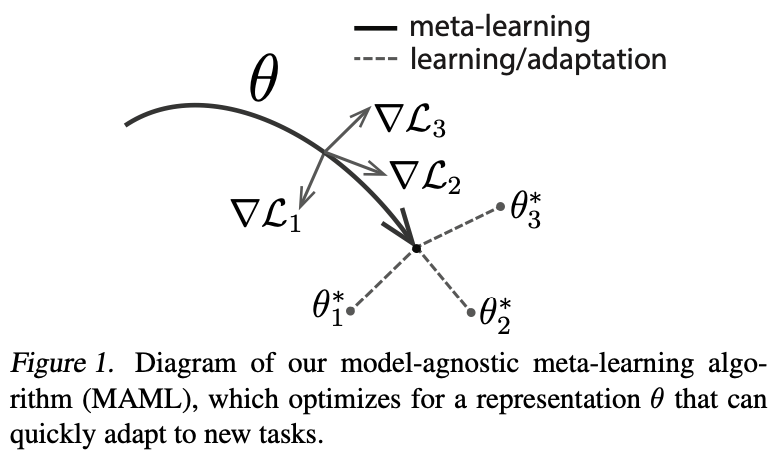

In [17]:
Image("Images/MAML-figure1.png")

Авторы не делают предположений о виде модели кроме того, что она параметризуется неким вектором параметров $\theta$ и что лосс достаточно гладок чтобы применять градиентные методы оптимизации.

Формально, модель представляется как параметризированная функция $f_\theta$ с параметрами $\theta$. Во время адаптации к новой задаче $T_i$, параметры $\theta$ становятся параметрами $\theta_i'$, значения которых находятся при помощи градиентного спуска на задаче $T_i$. Например, при использование одного градиентного апдейта:

$$
\theta_i' = \theta - \alpha\nabla_\theta L_{T_i}(f_\theta)
$$

Далее будем полагать, что происходит именно одно такое обновление параметров для каждой задачи.

Параметры обучаются на оптимизации качества $f_{\theta_i'}$ по отношению к $\theta$ над задачами, выбранными из $\rho(T)$. Более конкретно, meta-objective:

$$
\underset{\theta}{min}\sum\limits_{T_i\sim\rho(T)}L_{T_i}(f_{\theta_i'}) = \sum\limits_{T_i\sim\rho(T)}L_{T_i}(f_{\theta-\alpha\nabla_\theta L_{T_i}(f_\theta)})
$$

Важно отметить, что минимизация происходит именно по параметрам $\theta$, в то время как лосс считается на параметрах $\theta'$.

Таким образом, предложенный метод старается оптимизировать параметры модели так, чтобы небольшое число шагов градиентного спуска (в нашем случае один) на новой задаче давало маскимально эффективное поведение на ней.

Мета-оптимизация над задачами производится при помощи SGD, параметры модели обновляются по формуле:

$$
\theta \leftarrow \theta - \beta\nabla_\theta\sum\limits_{T_i \sim \rho(T)}L_{T_i}(f_{\theta_i'})
$$

где $\beta$ - мета размер шага. Полный алгоритм имеет вид:

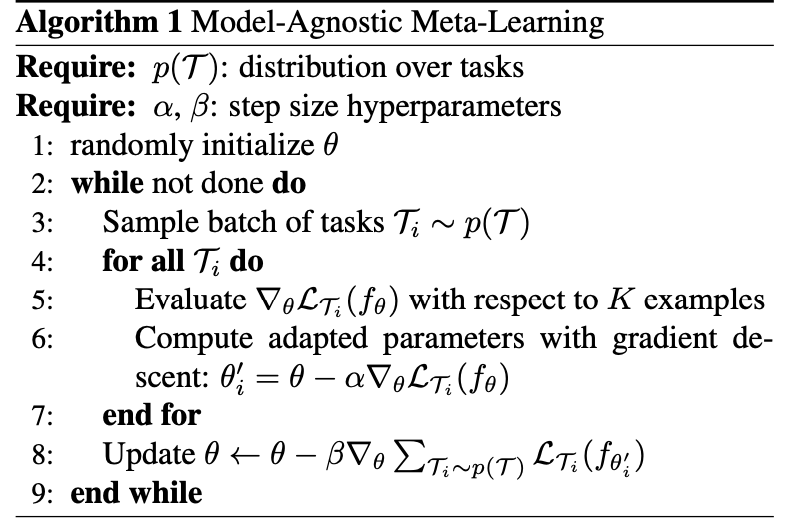

In [18]:
Image("Images/MAML-alg1.png")

Таким образом, MAML мета-градиентный спуск включает в себя градиент над градиентом.

### Виды MAML

#### Supervies Regression and Classification

Считаем H=1, то есть модель принимает и выдает один элемент, а не последовательность. Задача $T_i$ генерирует K i.i.d наблюдений из распределения $q_i$, лосс отображает ошибку между предсказанием модели и таргетом. 

Две общие функции лосса, используемые для обучения с учителем - кросс-энтропия и MSE. Для задачи регрессии имеем:

$$
L_{T_i}(f_\Phi) = \sum\limits_{x^{(j)},y^{(j)} \sim T_i}||f_\Phi(x^{(j)}) - y^{(j)}||^2_2
$$

в задаче K-shot суммирование берется по K парам.

Аналогично, для дискретной классификации с кросс-энтропией:

$$
L_{T_i}(f_\Phi) = \sum\limits_{x^{(j)},y^{(j)} \sim T_i}y^{(j)}log\:f_\Phi(x^{(j)}) + (1-y^{(j)})log\:(1-f_\Phi(x^{(j)}))
$$

Итоговый алгоритм имеет вид ((2) и (3) - наши лоссы, введенные выше):

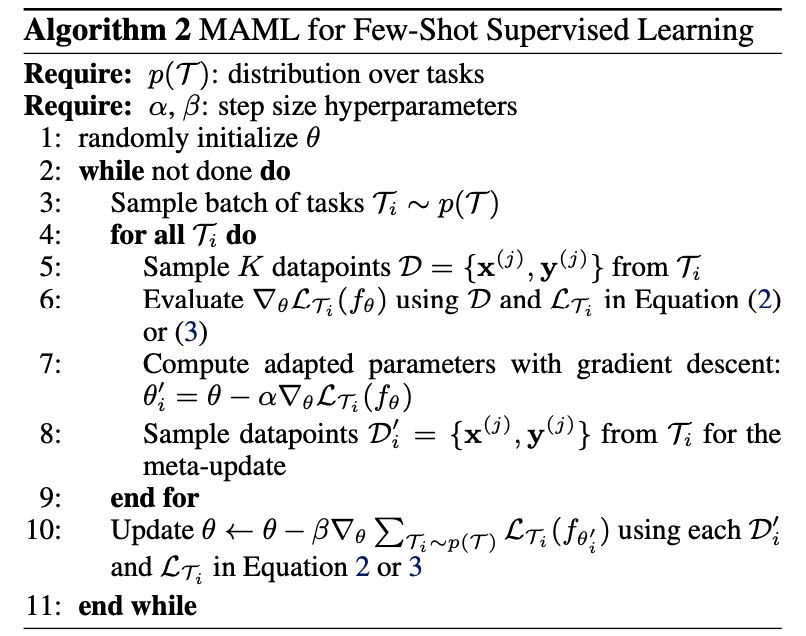

In [19]:
Image("Images/MAML-alg2.png")

Сложно нетрудно видеть, что мы как бы сначала смотрим, как бы обновились параметры на задаче K-shot. И делаем шаг градиентного спуска так, чтобы обновленные параметры давали на всех остальных наших данных наименьший лосс, то есть чтобы модели как можно лучше "научилась" на тех K примерах.

#### Reinforcement Learning

Приведу чисто алгоритм

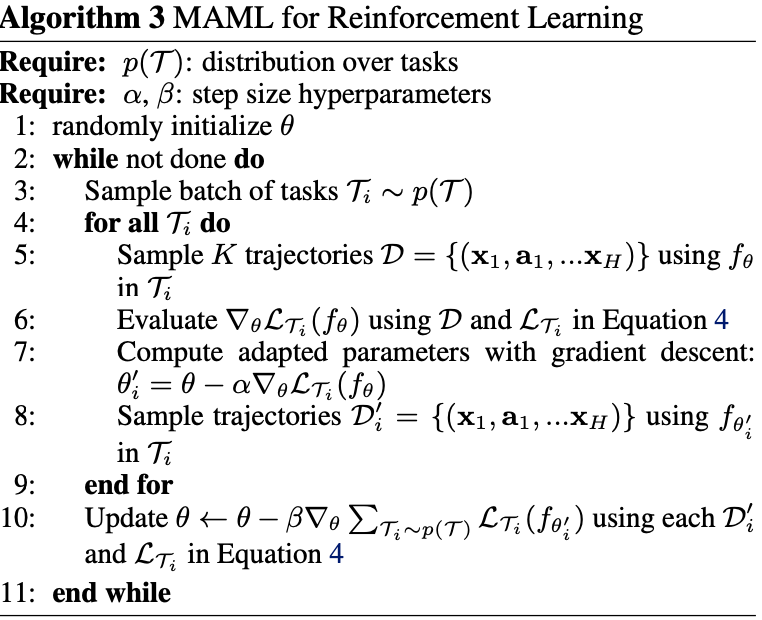

In [20]:
Image("Images/MAML-alg3.png")

#### Related Work

Сравнивая свой алгоритм с другими, авторы подчеркивают, что они не искользуют никаких дополнительных параметров для мета-обучения и не спицифицируются ни на какой конкретной архитектуре модели.

#### Experimental Evaluation

Ну и на последок, MAML сравнивается с кем только можно и всех побеждает:)

## <a id=11>A Survey on Multi-Task Learning</a>

https://arxiv.org/pdf/1707.08114.pdf

#### Abstract

Multi-Task Learning (MTL) - подход в машинном обучении, позволяющий использовать полезную информацию, скрытую в различных задачах, для улучшения обобщающей способности всех задач, объединив их в одну модель. В статье рассматриваются различных подходы мультитаска, теория, использование в различных задачах и дальнейшее развитие.

#### Introduction

В машинном обучении для решения какой-либо задачи очень часто нужна тонна данных, но в распоряжении они далеко не всегда. Именно это проблему и призван решить MTL подход, в котором куча различных задач объединяются в одну общую модель. Обучаясь таким образом этим задачам одновременно, мы можем получить значительный профит в перформансе, экономя при этом данные и не пытаясь обучиться каждой задаче по отдельности.

Это похоже на трансфер лернинг, однако есть значительно отличие. В трансфере мы значительным образом фокусируемся на целевой задаче, забывая при этом, на чем там изначально обучалась модель (или часть модели), в мтл же нет такой явной фокусировки на цели. Однако, при желании, она тоже возможна.

### MTL Models

Пусть даны m связанных задач $\{T_i\}_{i=1}^m$. Цель МТЛ - улучшить производительность каждой задачи $T_i$, используя знания, скрытые в других похожих задачах. Сфокурисуемся сначала на обучении с учителем: пусть нам для каждой задачи $T_i$ дан датасет $D_i = \{x^i_j, y^i_j\}_{j=1}^{n_i}$,  $x^i_j \in \mathbb{R}^{d_i}$, $y^i_j$ - лейблы. Обозначим матрицу $X^i = (x^i_1, x^i_2, \dots, x^i_{n_i})$. Если различные задачи имеют одни и те же датасеты, то МТЛ сводится к мульти-лейб лернингу. Мы будем считать, что все датасеты различны. Также будем считать, что все размерности $d_i$ равны ( _homogeneous MTL_ ).

При работе с MTL возникают несколько важных вопросов. Надо понять, _что делить?_. Вариантов тут несколько, существуют три основных подхода: feature-based (когда мы пытаемся выучить, полезные для различных задач), instance-based (найти данные, которые будут полезными для нескольких задач) и parameter-based, когда задачи имеют общие параметры (коэффициенты). Самые популярные из них - первый и третий, именно на них будет фокус. 

Еще один важный вопрос - _как делить?_. В feature-based подходе все понятно: используя какие-то feature learning модели мы, давая им на вход исходные представления, получаем некоторые фичи, которые затем используются для различных задач. В parameter-based подходе существуют 4 основных подхода: low-rank approach (интепретирует взаимосвязь нескольких задач как низкоразмерную матрицу параметров этих задач), task clustering approach (предполагает, что все задачи формируют несколько кластеров, где задачи в одном кластере связаны друг с другом), task relation learning (его цель - обучиться численным оценкам связей между задачами, используя данные) и decomposition approach (разбивает все параметры всех задач на две или более компоненты, которые штрафуются различными регуляризаторами (что??)).

В сумме получаем 5 подходов, далее их и обсудим.

#### Feature Learning Approach

Так как задачи связаны, то идея делить фичи звучит вполне разумно. Feature learning approach разделяется на два суб-подхода: feature transformation approach (преобразование исходных представлений) и feature selection approach (выбор "полезного" подмножества исходных фич).

__Feature Transformation Approach__

Примером такой архитектуры является следующая shallow net:

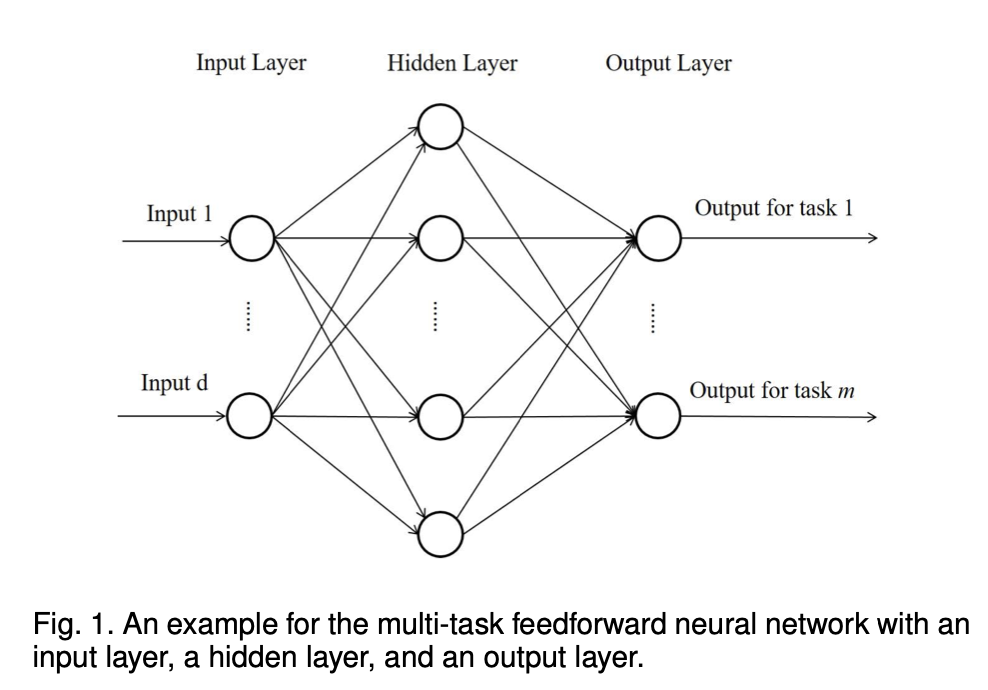

In [24]:
Image("Images/MultiSurvey-model1.png")

Помимо такой архитектуры, авторы кратко описывают multi-task feature learning (MTFL) и multi-task sparse coding методы, в которых трансформации фичей обучаются с использоваием специфичных objective функций. Помимо мелких (shallow) сетей, очевидно, бывают и архитектуры по-крупнее. Как пример - можно просто сделать сеть по-глубже, где часть слоев будут общими, а часть - специфичными. Еще один способ огранизации связи между задачами - cross-stitch network, в которой обучаются взаимосвязи между скрытыми слоями параллельно работающих сеток.

Пример такой сети выглядит так:

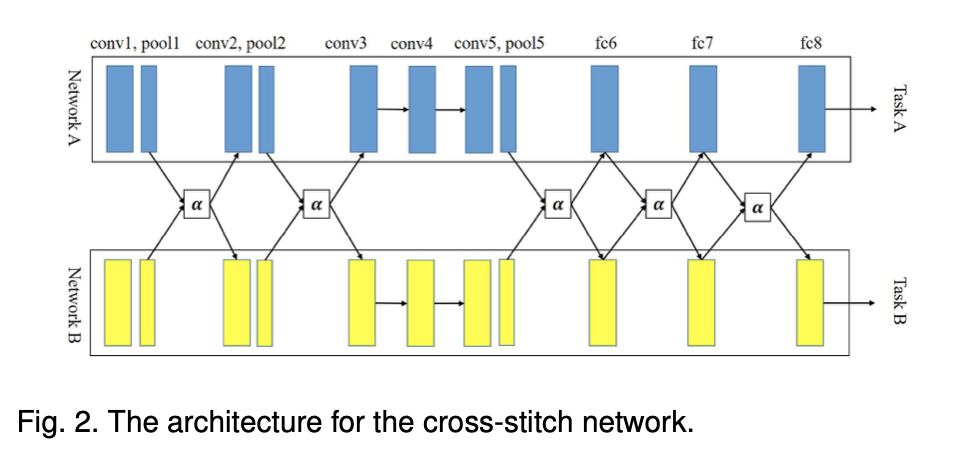

In [25]:
Image("Images/MultiSurvey-model2.png")

В ней, выходы со скрытых слоев проходят через линейное преобразование $\alpha$ и добавляются ко входам в скрытые слои "параллельной" сети.

__Feature Selection Approach__

Множество подходов в отборе фичей имеют следующий вид:

$$
\underset{W, b}{min}\:L(W, b) + \lambda||W||
$$

Где $||\cdot||$ - какая-то матричная норма ($1,2,p,\infty$), L(W,b) лосс модели, к которому мы добавили регуляризацию на W. Делая регуляризацию достаточно большой, мы "побудим" матрицу фичей W быть разреженной, а значит - проведем отбор.

Также есть подходы отбора фичей, основанные на предсказании вероятности того, что она нужна, при помощи Байесовских подходов.

__Comparison between Two Sub-categories__

Если коротко - feature transformation эффективнее и более гибок, feature selection approach - дешевле и более интерпретируемый.



#### Low-Rank Approach



Продолжение следует.... (сёрвей хардовый по теории, сходу его не одолеть)

## <a id=12>Generalizing from a Few Examples: A Survey on Few-Shot Learning</a>

https://arxiv.org/pdf/1904.05046.pdf

#### Abstract

В своей статье авторы решила сделать подробный обзор современным методам обучения на малом объеме данных. Решению именно этой проблемы посвящен Few-Shot Learning (FSL). Авторы делят его подходы на три основных типа: (i) данные, которые используют предварительные знания для расширения "контролируемого опыта" (supervised experience), (ii) модели, которые используют предварительные знания для снижения размера пространства гипотез, и (iii) алгоритмы, ипользующие предварительные знания для поиска лучших гипотез в данном пространстве гипотез. Все эти подходы будут описаны далее.

#### Introduction

Авторы приводят мотивацию для изучения и развития few-shot learning подходов, основываясь на жизненных примерах, когда они реально оказываются полезными. Их цель - систематизировать имеющиеся сейчас подходы и методы. В статье приводится:

* Формальное определение FSL

* Перечисляются современные проблемы, решающиеся при помощи FSL

* Отмечается основная проблема FSL-подходов - ненадежный эмпирический минимизатор рисков, основанный на декомпозиции ошибок

* Проводится обзор статей

* Предполагаются дальнейшие пути развития FSL

__Notattion and Terminology__

Рассмотрим задачу $T$, FSL работает с данными $D =\{D_{train}, D_{test}\}$, $D_{train} = \{(x_i, y_i)\}_{i=1}^I$, I - мало. Допустим, $p(x,y)$ - истинное совместное распределение вероятностей, а $\hat{h}$ - оптимальная гипотеза, которую пытается получить FSL, обучаясь на треине. Для ее оценки FSL определяет пространство гипотез $H$, в котором содержается гипотезы $h(\cdot;\theta)$, $\theta$ - все параметры, используемые функцией $h$. Таким образом, FSL-алгоритм по сути является оптимизайзером, который исследует пространство гипотез $H$, пытаясь найти параметры $\theta$, дающие лучший $h^* \in H$. Качество измеряется при помощи лосса $l(\hat{y}, y)$, где $\hat{y} = h(x;\theta)$ - предсказание модели.

### Overview

В этой части статьи дается определение FSL и приводятся основные области его применения: few-shot classification, regression и reinforcement learning. Приводя некоторые примеры, авторы выделяют то, что FSL-методы используют "предварительные знания" (prior knowledges), полученные из схожий задач, в которых доступно много данных, или еще каким-то способом еще до того, как модели дали выборку для обучения целевой задаче.

#### Relevant learning problems

* Weakly supervised leaning - обучение со "слабым учителем" (неполные, неточные, шумные данные). Самое популярное - _weakly supervised learning with incomplete supervision_, которая лишь небольшое число примеров из всех имеет разметку. В зависимости от того, используется оракул или человек, разделение идет еще на две задачи:

    * Semi-supervised learning, когда обучение идет на небольшом количестве размеченных данных и обычно большом объеме неразмеченных. Часто используется в текстах и классификации вебстраниц.
    
    * Active learning - выбор информативных неразмеченных данные для запроса оракулу на целевой аутпут. Примерняется, когда разметка дорога.
    
FSL относят к weakly supervised learning ровно тогда, когда у нас в качестве предварительных знаний есть неразмеченные данные, а задача - классификация или регрессия.

* Imbalanced learning - обучение на данных с сильно смещенным распределеним ответов. Такое случается, когда некоторые события из y случаются относительно редко (fraud, катастрофы). FSL отличается от него тем, что он заранее нецелен на тренировке на небольшом числе примеров, а остальные y-ки можно использовать как предварительные знания.

* Transfer learning - перенос знаний с отдной задачи (домена) с большим числом данных на другую задачу, где данных мало. Domain adaptation - тип трансфер лернинга, в котором исходная и целевая задача одинаковы, но данные в них берутся из разных областей (доменов). Transfer learning часто используется в FSL, когда предварительные знания переносятся с одной задачи на задачу few-shot.

* Meta-learning - в этоп подходе используются мета-знания о каких-то общих структурах задач и тому, как им обучиться, чтобы потом дообучиться на новую задачу. Meta-learning подходы часто используются для решения задачи FSL.

#### Core issue

Для гипотезы $h$ расмотрим _ожидаемый риск_ $R$ (supervised задача):

$$
R(h) = \int l(h(x), y)\:dp(x,y) = \mathbb{E}[l(h(x), y]
$$

его мы хотим минимизировать. Однако, $p(x,y)$ нам не дано, дана лишь выборка. Так мы приходим к _эмпирическому риску_ (усреднение ошибок на треине):

$$
R_I(h) = \frac{1}{l}\sum_{i=1}^{I}l(h(x_i),y_i)
$$

Обозначим:

* $\hat{h} =  argmin_hR(h)$

* $h^* = argmin_{h\in H}R(h)$

* $h_I = argmin_{h\in H}R_I(h)$

$\hat{h}$ - неизвестна, ее лучшая оценка находится во множестве $H$, где мы ищем гипотезу. Лучшая в нем - гипотеза $h^*$, кторую мы можем оценить лишь эмпирическим риском $h_I$. полная ошибка расписывается как:

$$
\mathbb{E}[R(h_I)-R(\hat{h})] = \mathbb{E}[R(h^*)-R(\hat{h})] + \mathbb{E}[R(h_I)-R(h^*)]
$$

Первую часть называют ошибкой аппроксимации $\varepsilon_{app}(H)$, вторую - ошибкой оценки $\varepsilon_{est}(H,I)$. Стараясь уменьшить общую ошибку, мы можем попробовать изменить (i) данные ($D_{train}$), (ii) модель (определяет пространство гипотез $H$) и (iii) алгоритм (ищет в $H$ гипотезу $h_i$, обучаясь на треине.

__Unreliable Emperical Risk Minimmizer__

Тут становится сразу понятным ключевая проблема фьюшота: нехватка данных и риск переобучиться на имеющиеся данные, то есть минимизатор эмпирического риска $h_I$ перестает быть надежным. Это можно изобразить следующим образом:

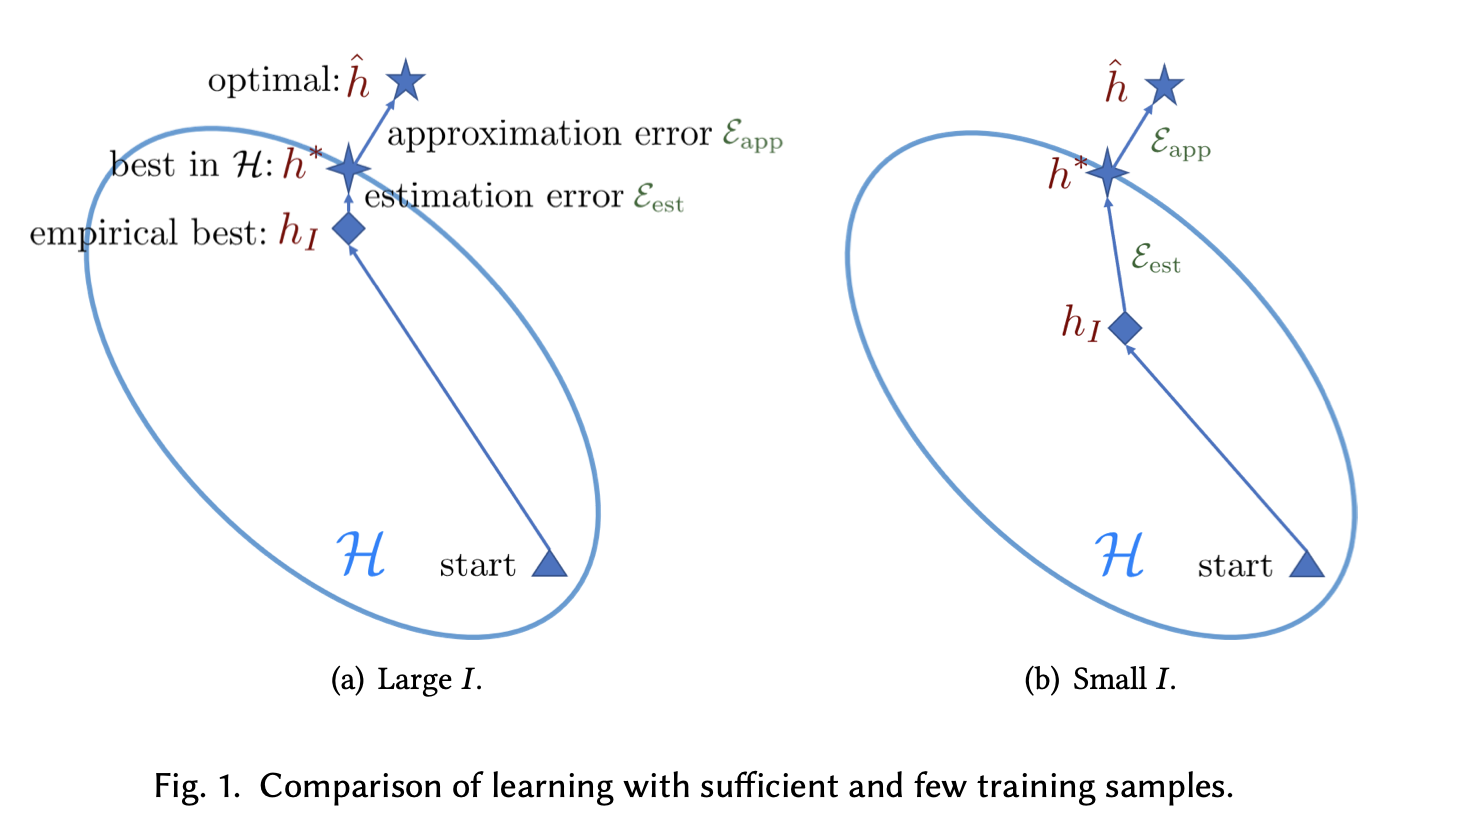

In [26]:
Image("Images/Few-shot-survey1.png")

#### Taxonomy

Чтобы облегчить проблемы ненадежного минимизатора эмпирического риска, можно попробовать использовать какие-то предварительные знания, что и делается в FSL. Такие подходы можно разделить на три основных:

* Аугментация данных треина.

* Модели, в которых заключено понимание ограничений сложности пространства $H$, что приводит к меньшему пространству поиска $\tilde{H}$.

* Алгоритмы, использующие предварительные знания для поиска лучших параметров $\theta$. Такими знаниями могут быть либо хорошие стратегии инициализации, либо лучшее понимание того, как надо двигаться. 

Эти подходы можно изобразить следующим образом:

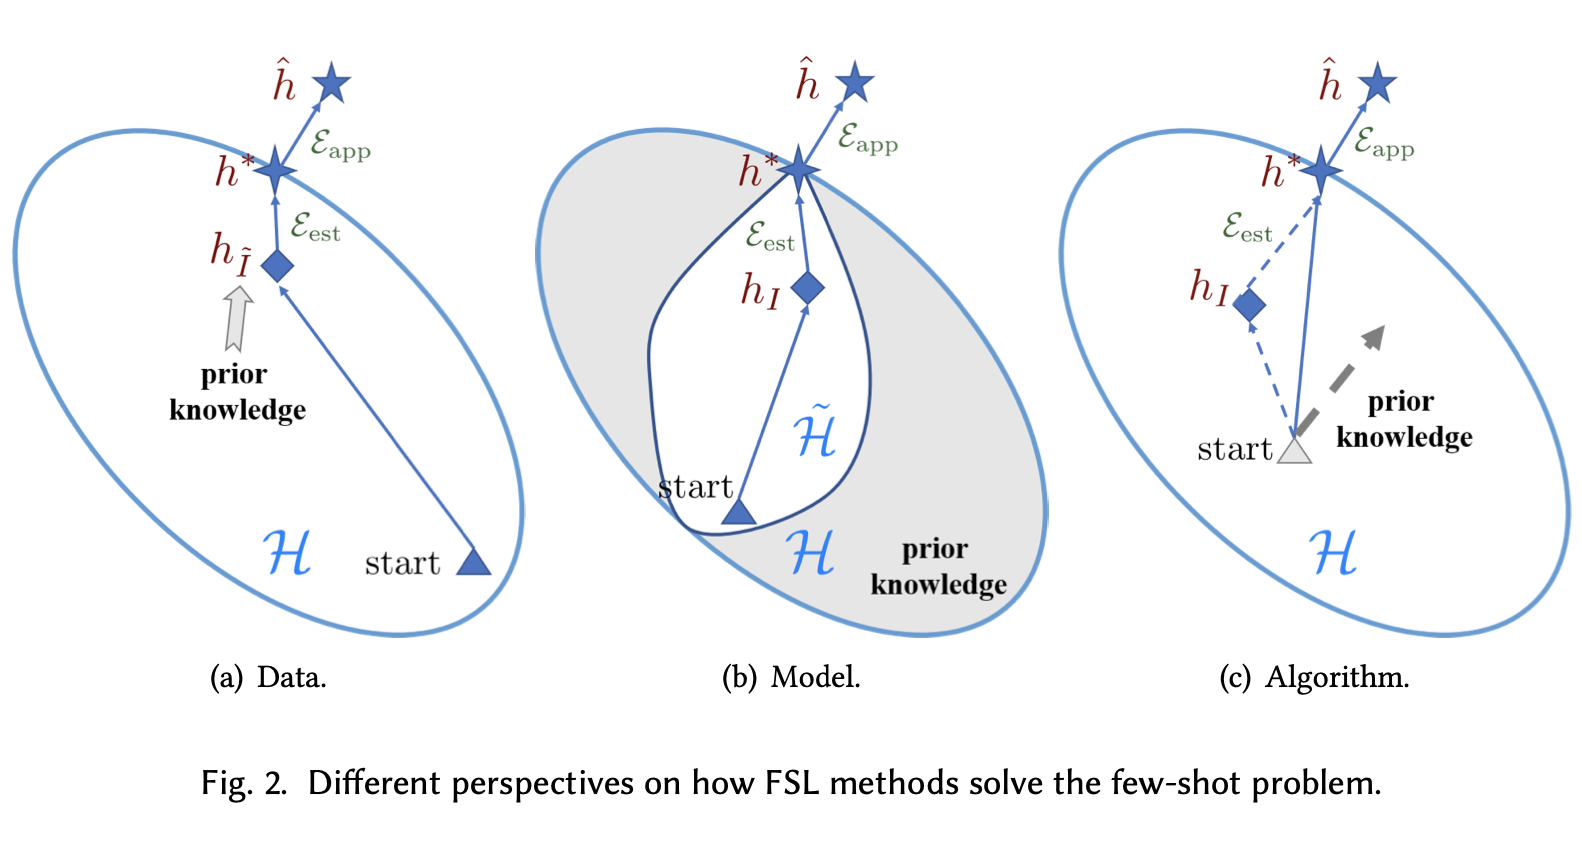

In [28]:
Image("Images/Few-shot-survey2.png")

Систематизировать указанные подходы можно так:

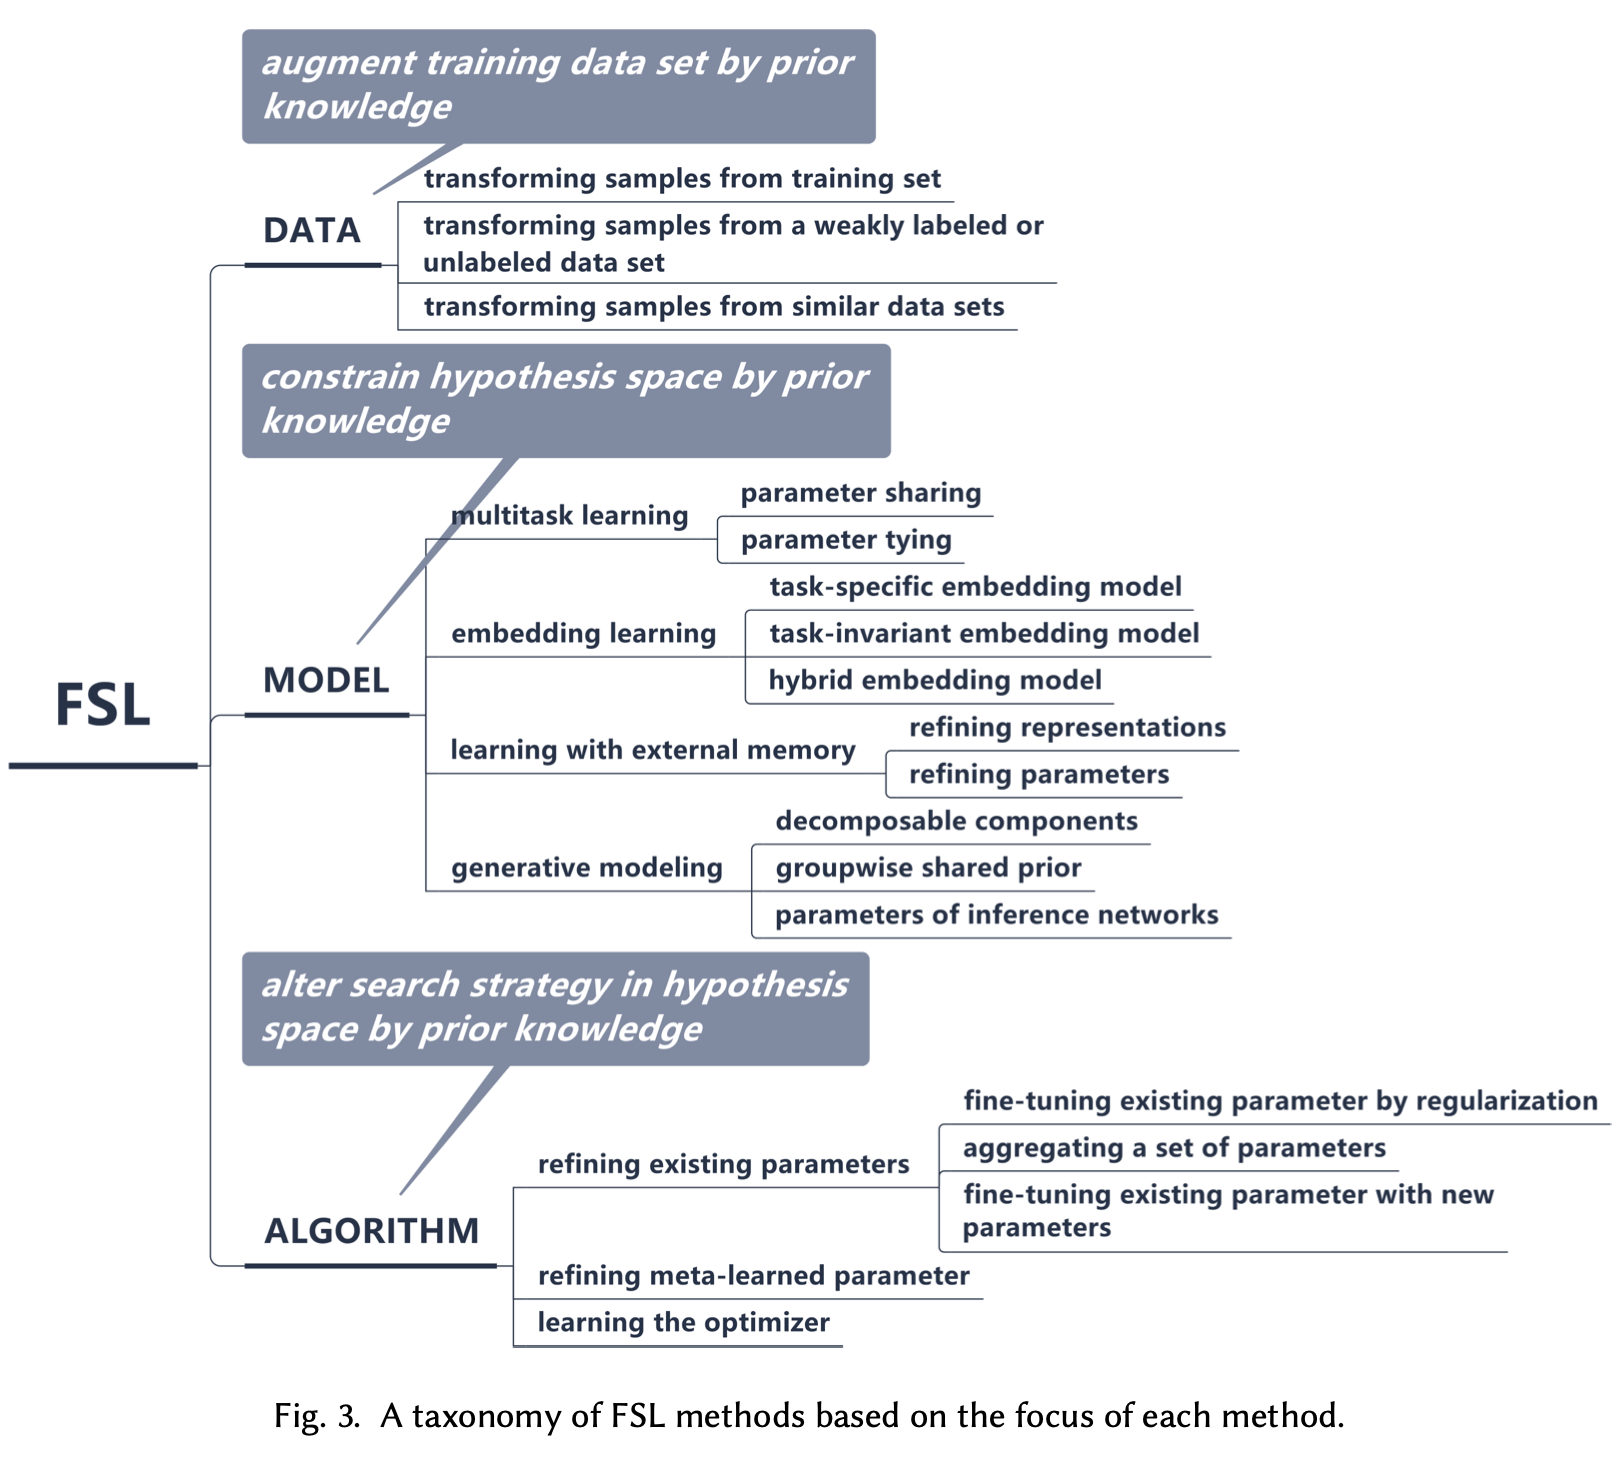

In [29]:
Image("Images/Few-shot-survey3.png")

### Data

В этой части рассказываются различные способы аугментации данных, такие как создание новых примеров обучения вручную (transforming samples from $D_{train}$), добавление в треин примеров из слабо размеченных или неразмеченных данных (transforming samples from a Weakly Labeled or Unlabeled Data Set), однако там встает вопрос, каким образом эти данные лучше выбирать, для чего используются либо дополнильные классификаторы, либо label propogation. Еще один подход - использование примеров из схожие датасетов (transorming samples from similar dataset), однако просто встроить примеры не всегда так просто - авторы упоминают использоваие GAN-ов.

В качестве небольшого саммари авторы говорят о том, что выбор стратегии аугментации зависит от самой задачи и в целом, этот подход достаточно прямолинеен и эффективен. Однако, такие стратегии все же лучше подходят для работы с картинками, чем, например, с текстом (однако и в нем есть некие попытки (J. Wei and K. Zou. 2019. EDA: Easy data augmentation techniques for boosting performance on text classification tasks.)

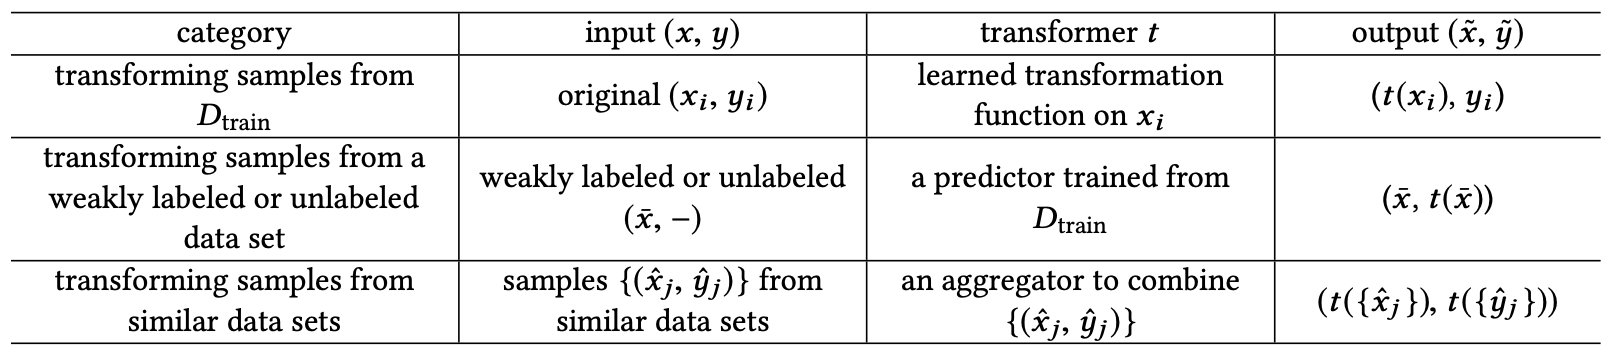

In [30]:
Image("Images/Few-shot-table1.png")

### Model

Так как модели определяют пространство поиск гипотез, то вполне резонно попыаться зашить в модель какие-то предварительные знания об области и, таким образом, сузить пространство поиска и получить более надежный минимизатор эмпирического риска и с уменьшением вероятности переобучения. Таблица основных подходов:

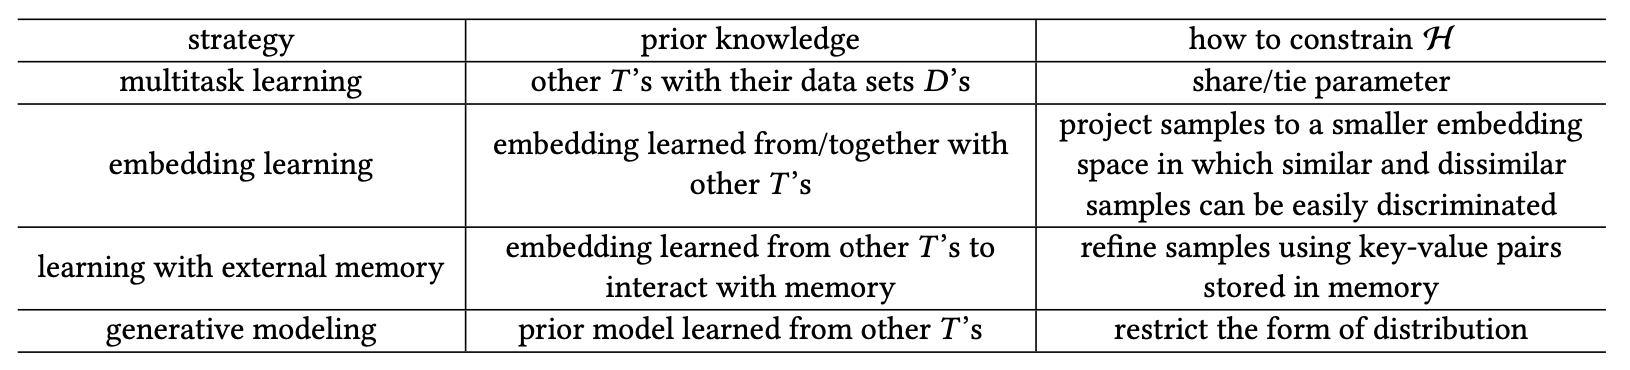

In [31]:
Image("Images/Few-shot-table2.png")

#### Multitask learning

Это подход обучает одновременно несколько связанных задач за счет использования как общей, так и специфичной информации. Именно поэтому, MTL используется для FSL. 

Пусть нам даны C всязанных задач $T_1, \dots, T_C$, некоторые из которых имеют лишь совсем немного примеров, а другие - напротив, много. Для каждой задачи $T_c$ у нас есть датасет $D_c = \{D_{train}^C, D_{test}^c\}$. Среди всех C задач few-shot-ы обозначим за target tasks (целевые задачи), а остальные - source tasks (исходные задачи). MLT старается, имея $D_{train}^c$ получить параметры $\theta_c$ для каждой задачи $T_c$. Так как задачи обучаются совместно, то возникают ограничение, которые они друг на друга накладывают (то есть таким образом сужается пространство поиска решений). Существуют два основные подхода мультитаска: parameter sharing и parameter tying.

__Parameter sharing__

Суть в том, что несколко задач имеют общие параметры. Это может быть, например, наличие первых общих слоев для получения общей информации, за которыми идут task-specific слои, дающие выход для каждой из задачи. Также можно обучить модель, которая будет сначала просто извлекать связанные с областями задач части (например, какие-то тематические части текста), а затем, классифицировать эти части (или токены) на принадлежность конкретной из целевых задач (хорошая идея!).

Помимо этого, есть варианты с предобучением всяких auto-encoder-ов на исходных задачах с кучей данных, которые затем переносятся на целевые задачи, где помогают ивзлекать некоторые общие представления о тексте. При этом, целевые задачи смогут обновлять лишь свои, специфичные части, в то время как source task может обновлять всю модель.

Иногда можно сначала попробовать получить эмбеддинги для каждой из задач, а потом скормить их общему variational auto-encoder-у.

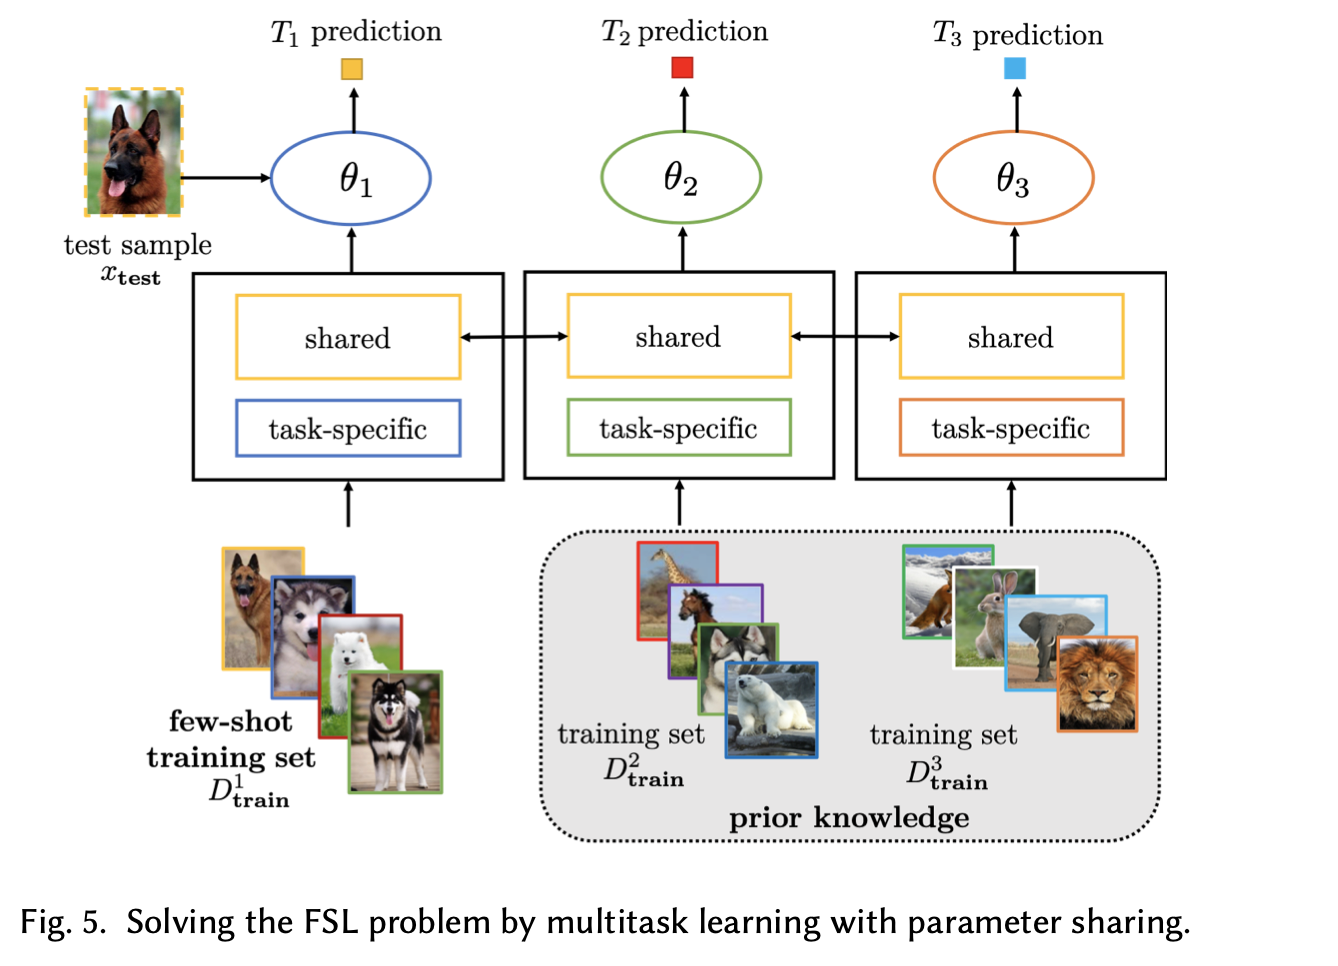

In [32]:
Image("Images/Few-shot-survey4.png")

__Parameter tying__

Стратегии поощерения параметров различных задач быть похожими друг на друга. Популярный подход в регуляризации $\theta_c$. Иногда, например, люди штрафуют попарную разницу $\theta_c$.

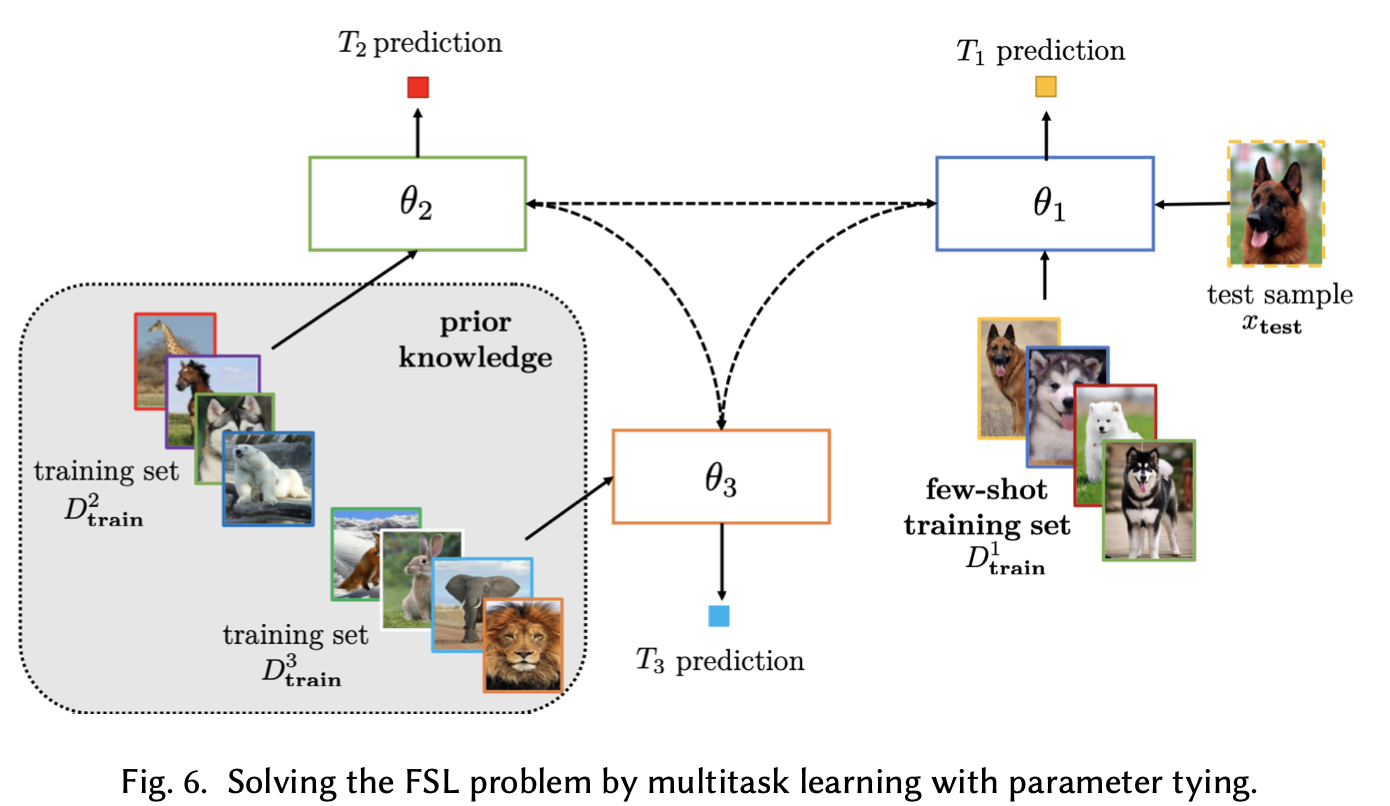

In [33]:
Image("Images/Few-shot-survey5.png")

#### Embedding Learning

В этом подходе каждый сэмпл $x_i \in X \subseteq \mathbb{R}^d$ переводится в низкоразменое представление $z \in Z \subseteq \mathbb{R}^m$ так, что похожие примеры становятся близки друг к другу, в то время как различные примеры становятся легко различимы. Уменьшая размерность пространства представлений, мы тем самым сужаем пространство гипотез, в которых ищем решение и, соотвественно, требуем меньше примеров. Эмбеддинг-функция обычно обучается на предварительных знаниях и может также использовать какую-то специфичную информацию из $D_{train}$.

Все подходы Embedding Learning можно объединить в следующую таблицу:

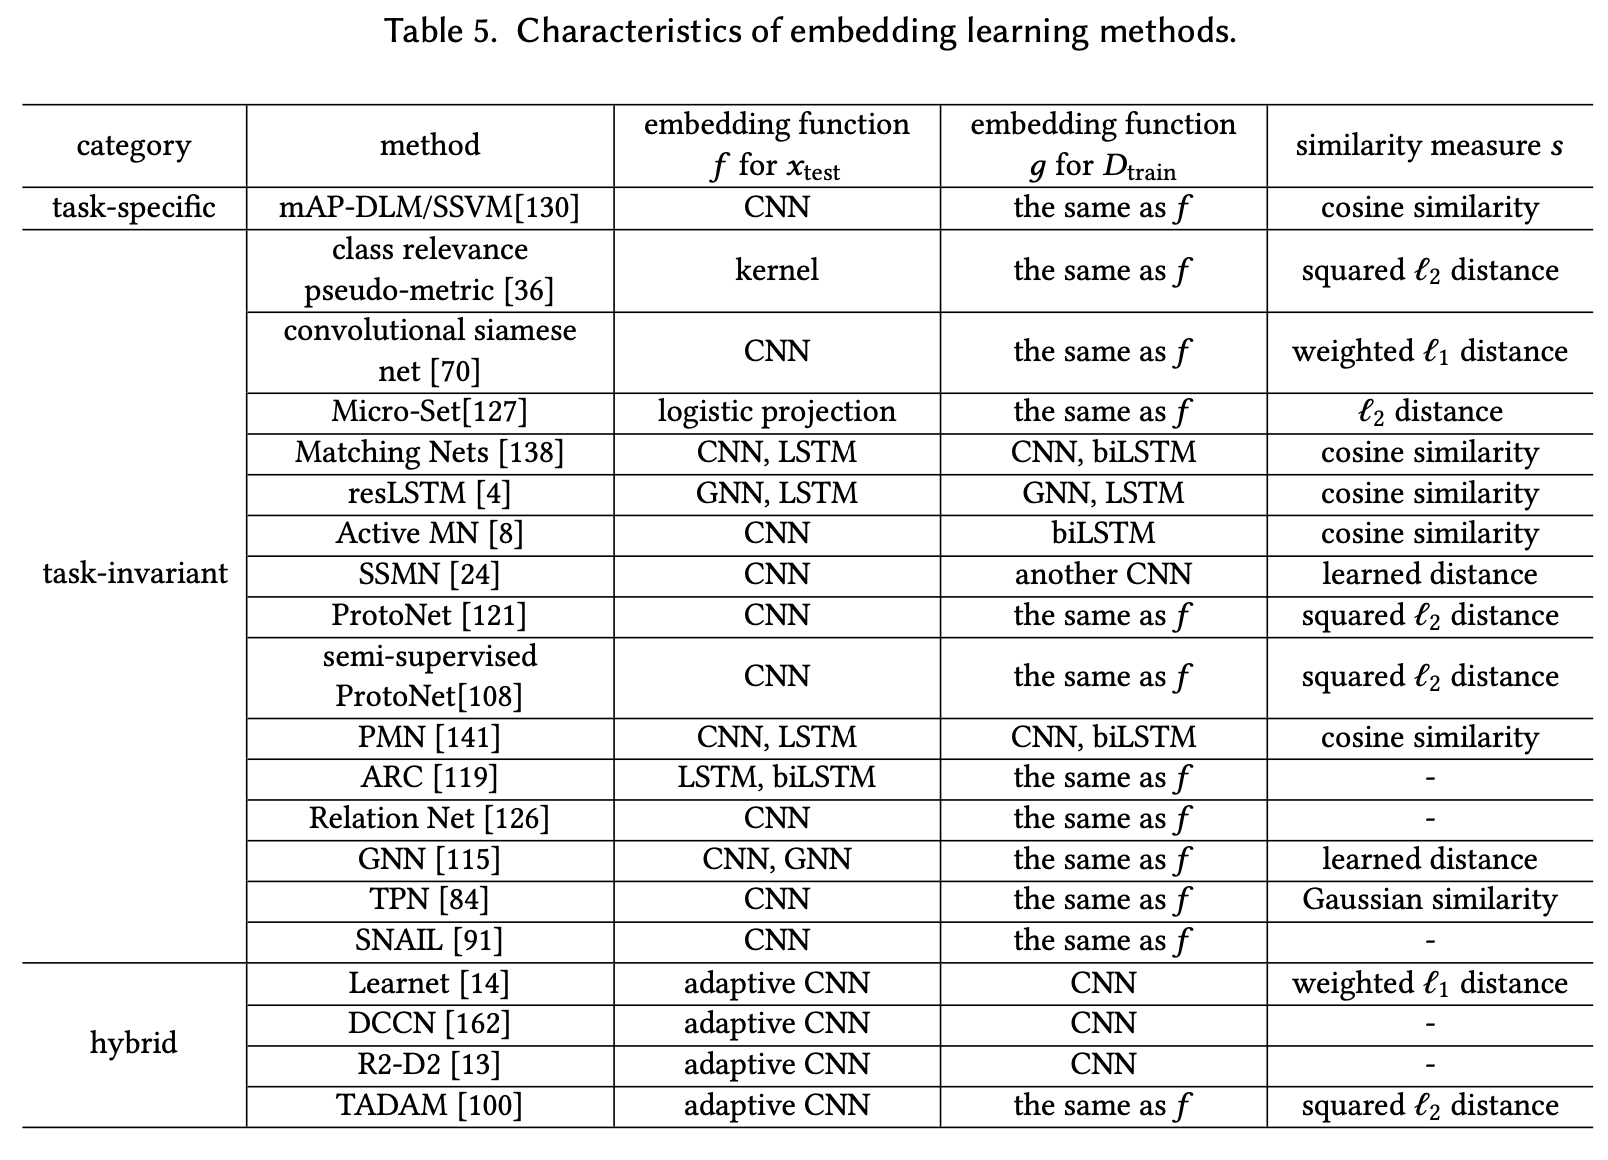

In [34]:
Image("Images/Few-shot-table3.png")

__Task-specific Embedding Model__

В ней для каждой задачи, используя соотвествующий few-shot датасет обучается функция получения эмбеддинга для этой задачи.

__Task-invariant Embedding Model__

Модель сначала пытается выучить функцию получения эмбеддингов на каком-то большом датасете и разнообразом датасете, а затем использует ее на новых few-shot задачах без дообучения. Первые такие модели для получения представлений использовали kernel-ы, теперь популярны convolutional siamese.

Классических подход - вырезать из N классов треина U классов, обучаться на них, а оптимизироваться на оставшихся N-U классах, обучаясь таким образом фью-шоту. Популярные виды сетей:

* Matching Nets - обучает функции эмбеддингов для треинов и тестов, например, при помощи residual LSTM (resLSTM). Есть также и вариант с active learning.

* Prototypical Networks (ProtoNet) - мы описали ранее. В них находятся прототипы каждого из классов как среднее эмбеддингов. Затем, эмбеддинг теста сравнивается с каждым из прототипов.

* Other methods - например, LSTM с atterntion-ом, Relation Net, Graph neural network (GNN).

__Hybrid Embedding Model__

В этом подходе используются как общие эмбеддинги, так и эмбеддинги, заключающие в себе информацию о некоторой задаче.

#### Learning with External Memory

В этом подходе из треина извлекаются некоторые знания, которые затем сохраняются во внешней памяти. Каждый сэмпл из теста представляется как взвешенное среднее содержания памяти. Таким образом, мы ограничиваем размер пространства H.

#### Generative Modeling

В нем оценивается вероятностное распределение из рассмотренного $x_i$ при помощи предварительных знаний. Такие. методы чаще всего используются в задачах генерации, распознования, реконструкции и image flipping.

#### Disussion and Summary

И тут самое весело - авторы утверждают, что мультитаск подходит лишь для совместного обучения, но никак не для дообучения на новую задачу. Более того, они утверждают, что размер преодбучающей выборки и выборки для задачи должны быть несопоставимы, иначе, few-shot таск может быть повержен задачей с большим объемом сэмлпов.

Когда есть достаточно много данных с достаточным числом примеров нескольких классов, хорошо подходит embedding learning подход.

Когда есть возможность хранить данные - можно использовать memory network, что даст возможность обучить чуть ли не простой линейный классификатор. Однако, это дорогой подход.


### ALGORIGHM

Алгоритм - это стратегия поиска гипотезы в прострастве H для нахождения параметров $\theta$, дающих $h^*$. На t-ой итерации $\theta_t = \theta_{t-1}+\Delta\theta{t-1}$, где $\Delta\theta{t-1}$ - обновление. Например, в СГД мы имеем:

$$
\theta{t} = \theta{t-1}-\alpha\nabla_{\theta{t-1}}l(h(x_t;\theta_{t-1}), y_t)$
$$

Если $\theta{0}$ - нулевое приближение, то на моменте t имеем:

$$
\theta_t = \theta_0 + \sum\limits_{i=1}^{t}\Delta\theta_i
$$

Когда в обучении много информации, то примеров может хватить для нахождения $\theta$ и даже $\alpha$ на кросс-валидации. Однако, это не про FSL.

Методы в этой части используют предварительные знания чтобы повлиять на то, каким образом алгоритм находит параметры, либо (i) хорошей инициализацией первого приближения, либо (ii) обучая оптимайзер тому, как он должен "шагать". В терминах того, каким образом предварительные данные влияют на стратегию обучения, эти методы можно разделить на:

1) Refining existing parameters. Начальный $\theta_0$ обучается на других задачах и дальше совершенствуется на треине

2) Refining meta-learned parameters. Начальный $\theta_0$ мета-обучен на наборе зач, взятых из того же task distribution как фью-шоты, а далее он улучшается на треинЕще 

3) Learning the optimizer. Эта стратегия обучает мета-лернереровский оптимайзер, который будет давать шаги лернеру напрямую.

Все это можно свести в таблицу:

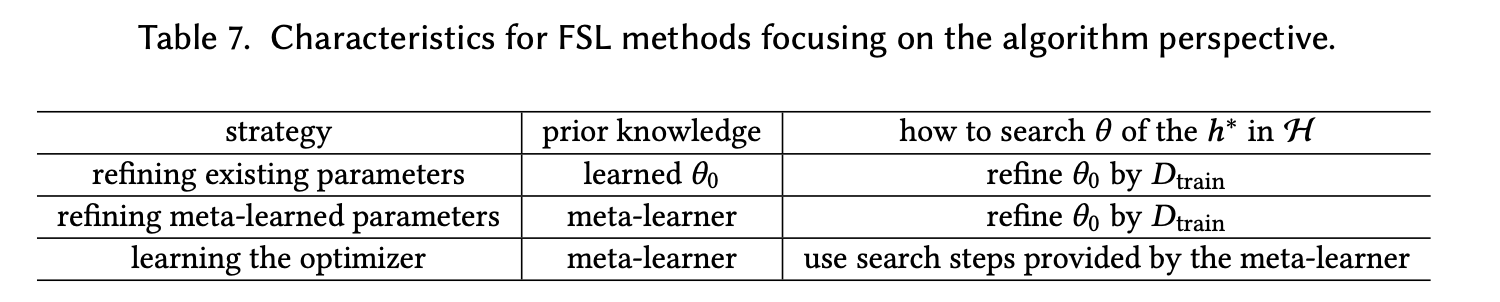

In [37]:
Image("Images/Few-shot-table4.png")

#### Refining Existing Parameters

Предположение в том, что $\theta_0$ может содержать в себе некоторые общие структуры, если обучен на множестве задач (на больших данных). 

__Fine-Tuning Existing Parameter by Regularization__ 

Сначала, нулевые приближение обучается на каких-то сторонних данных, затем, уже на нашей выборке его можно попробовать пофайнтьюнить при помощи градиентного спуска, но это может привести к переобучению. Чтобы этого избежать, используют различные стратегии регуляризации:

1) Early-stopping - остановка если нет улучшений в качестве

2) Selectively updating $\theta_0$ - обновляется лишь часть (напрмер, используется фильтр)

3) Updating related parts of $\theta_0$ together

4) Using a model regression network.

__Aggregating a Set of Parameters__

Если у нас есть набор моделей, обученных на похожих задачах, мы можем их аггрегировать в подходящую модель, которая дальше будет либо использоваться либо как есть, либо дофайнтьюнена.

Таким образом, мы можем взять нулевое приближение $\theta_0$, научившись "доставать" его из параметров других моделей (это обучение происходит либо на каких-то неразмеченных данных, либо на схожих датасетах).

__Fine-Tuning Existing Parameter with New Parameters__

Иногда предобученных $\theta_0$ может не хватать. В таком случае может помочь добавление новых параметров (каких-то слоев), которые будут снуля обучаться (наряду с файнтьюнингов уже имеющихся нулевых приближений) во время треина.

#### Refining Meta-Learner Parameter

Этот метод использует мета-лернинг для улучшения мета-обученных параметров $\theta_0$. Мы непрерывно оптимизируем нулевое приближение мета-лернера в соотвествии с качеством лернера.

Мета-обученное нулевое приблжение обычно улучшается при помощи градиентного спуска. Один из показательных примеров - MAML. Он мета-обучает $\theta_0$, который потом настраивается для получения хороших task-specific параметров $\Phi_s$ для задачи $T_s \sim P(T)$  при помощи градиентного спуска как: $\Phi_s = \theta_0 - \alpha\nabla_{\theta_0}L^s_{train}(\theta_0)$, где $L^s_{train}(\theta_0)$ - сумма ошибок над $D_{train}$. Мета-обученные параметры $\theta_0$ обновляются в соотвествии с фидбеком от множества мета-треин задач: $\theta_0 \leftarrow \theta_0 - \beta\nabla_{\theta_0}\sum_{T_s\sim P(T)}L^s_{test}(\theta_0)$. Непрерывно прокачивая нулевое приближение на few-shot сэмплах, мы начинаем быстрее адаптироваться к задаче.

В последнее время было предложено множество улучшений MAML. В целом, их можно разделить на три основных аспекта:

1) Incorporating task-specific information - предлагается выбирать нулевое приближение параметров модели из множества хороших иницииализаций

2) Modeling the uncertainty of using a meta-learned $\theta_0$ - обучение на нескольких примерах неизбежно ведет к модели с большой неуверенностью. Способность измерить эту неуверенность дает возможность использовать active learning подход для дальнейшего сбора данных. Существуют работы, которые учитывают неуверенность в мета-обученных $\theta_0$ или же неопределенность в $\Phi_s$.

3) Improving the refining procedure - тут предлагается некоторая регуляризация с использованием regression network

#### Learning the Optimizer

Такие методы предлагают вместо использования градиентного спуска (как в прошлом разделе) обучать оптимайзер, который будет напрямую давать обновление параметров. Не будет необходимости тюнить альфу или искать направление поиска так как алгоритм будет делать это сам. 

На t-ой итерации металернер принимает "сигнал" ошибки от итерации t-1, считает градиент и обновляет параметры, далее находит ошибку на t-ом шаге и отдает ее следующей итерации. После обучения задаче, мета-лернер улучшается при помощи градиентного спуска на тесте. После обучения на нескольких задачах из $P(T)$ мета-лернер прокачивается и мы имеем крутой алгоритм FSL. В последнее время популярен подход с LSTM.